# Generating Samples 

In [1]:
import torch
from tqdm import tqdm
# Check if CUDA is available and being used
cuda_available = torch.cuda.is_available()
current_device = torch.cuda.current_device() if cuda_available else 'CPU'
device_name = torch.cuda.get_device_name(current_device) if cuda_available else 'CPU'

print(f"CUDA Available: {cuda_available}")
print(f"Current Device: {current_device}")
print(f"Device Name: {device_name}")

CUDA Available: True
Current Device: 0
Device Name: NVIDIA TITAN X (Pascal)


In [2]:
import json
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from os import path

from data.datasets import postprocess
from models.glow_model.train import get_ds_params
from models.glow_model.model import Glow
from utilities.routes import OUTPUT_DIR

device = torch.device("cuda")
transform =None
# output_folder = 'models/glow_model_/output_additive_cifar10/'
dataset_output = "output_train_augmentation/"
# model_name = 'glow_model_250.pth'
ds_name = 'gtsrb'  # svhn
model_type = 'glow'

dataset_output_dir = path.join(dataset_output, f"{model_type}_{ds_name}/")

if ds_name == 'cifar10':
    model_name = 'glow_checkpoint_195250.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)

elif ds_name == 'svhn':
    model_name = 'glow_checkpoint_1144.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
elif ds_name == 'mnist':
    model_name = 'glow_checkpoint_11244.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
elif ds_name == 'imagenet32':
    model_name = 'glow_checkpoint_2001.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
elif ds_name == 'celeba':
    model_name = 'glow_checkpoint_2532.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
elif ds_name == 'gtsrb':
    model_name = 'glow_checkpoint_9860.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
elif ds_name == 'mixed':
    model_name = 'glow_checkpoint_2418.pt'

    ds_name_fit = 'gtsrb'
    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
# image_shape, num_classes, _, test_gtsrb = get_ds_params(ds_name_fit, hparams['dataroot'], transform, hparams['augment'], hparams['download'],mode='test')
# image_shape, num_classes, _, test_cifar = get_cifar10(hparams['augment'], hparams['dataroot'], hparams['download'])
# image_shape, num_classes, _, test_svhn = get_svhn(hparams['augment'], hparams['dataroot'], hparams['download'])
image_shape, num_classes, _, test_mixed = get_ds_params(ds_name, hparams['dataroot'], transform, hparams['augment'], hparams['download'],mode='test')

model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
             hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
             hparams['learn_top'], hparams['y_condition'])

model.load_state_dict(torch.load(dataset_output_dir + model_name)['model']) # Load only model part
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

/export/home/bmontaze/behrooz_vscode/repos/ood_detections/.venv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/models/glow_model/modules.py:482: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  w_init = torch.qr(torch.randn(*w_shape))[0]
/export/home/bmontaze/behrooz_vscode/repos/ood_detections/.venv/lib/python3.10/site-packages/torch/

In [3]:
def sample(model):
    with torch.no_grad():
        if hparams['y_condition']:
            y = torch.eye(num_classes)
            y = y.repeat(batch_size // num_classes + 1)
            y = y[:4, :].to(device) # number hardcoded in model for now
        else:
            y = None

        images = postprocess(model(y_onehot=y, temperature=1, reverse=True))
        # print(images)
    return images.cpu()

(-0.5, 171.5, 205.5, -0.5)

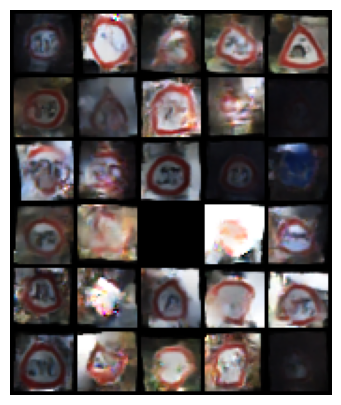

In [5]:
images = sample(model)

grid = make_grid(images[:30], nrow=5).permute(1,2,0)

plt.figure(figsize=(5,5))
plt.imshow(grid)
plt.axis('off')

In [ ]:
# Sampling from the Glow model and saving the images as .ppm files
import os
from PIL import Image
import torch
from tqdm import tqdm

def generate_and_save_batches(model, output_dir, total_samples=100000, batch_size=10000, prefix="sample", temperature=1.0):
    """
    Generate and save a specified number of samples in batches, as .ppm files for later use with DatasetFolder.

    Args:
        model: The Glow model.
        output_dir: Directory to save the images.
        total_samples: Total number of samples to generate.
        batch_size: Number of samples per batch.
        prefix: Prefix for saved images.
        temperature: Sampling temperature.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
    total_batches = total_samples // batch_size
    counter = 0

    for batch_idx in tqdm(range(total_batches), desc="Creating Batches: ", total=total_batches):
        images = []
        
        # Accumulate images until we reach the required batch size
        while len(images) < batch_size:
            with torch.no_grad():
                new_images = model(y_onehot=None, temperature=temperature, reverse=True)
                new_images = postprocess(new_images)  # Apply postprocessing to scale the images
                images.extend(new_images)  # Accumulate the images

        # Now we have at least 'batch_size' images (10000 in this case)
        cls_path = os.path.join(output_dir, str(batch_idx))
        os.makedirs(cls_path, exist_ok=True)

        # Save each image in the batch as .ppm using PIL
        for i, img in enumerate(images[:batch_size]):
            # Convert tensor to PIL Image
            img = img.permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
            img = Image.fromarray(img.cpu().numpy())  # Convert to a numpy array and then to PIL Image

            # Define the image path
            image_path = os.path.join(cls_path, f"{prefix}_{counter + i}.ppm")

            # Save the image
            img.save(image_path, format='PPM')  # Saving as PPM format explicitly

        counter += batch_size

    print(f"Generated and saved {total_samples} samples to {output_dir}")

# Directory to save the samples
# output_sample_dir = "data/CIFAR10/ppm_generated_samples/"
output_sample_dir = "data/GTSRB/ppm_generated_samples/"
total_samples = 100000
batch_size = 10000

# Generate and save samples
generate_and_save_batches(
    model=model,
    output_dir=output_sample_dir,
    total_samples=total_samples,
    batch_size=batch_size,
    prefix="sample",
    temperature=1.0
)



Creating Batches: 100%|██████████| 10/10 [22:07<00:00, 132.70s/it]

Generated and saved 100000 samples to data/GTSRB/ppm_generated_samples/


In [7]:
# Converting cifar test to .ppm images to be able to use them in the dataset folder for training

import os
from tqdm import tqdm
from torchvision import datasets

def convert_gtsrb_to_ppm(output_dir, dataroot, split="test", download=True, transform=None, prefix="gtsrb"):
    """
    Converts the GTSRB dataset images to .ppm format and saves them to a specified directory.

    Args:
        output_dir: Directory to save the converted images.
        dataroot: Root directory where the GTSRB dataset is or will be downloaded.
        train: Whether to use the training set (True) or test set (False).
        download: Whether to download the dataset if not present.
        transform: Transform to apply to the dataset images.
        prefix: Prefix for saved image filenames.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
    
    # Load the GTSRB dataset
    dataset =  datasets.GTSRB(
            dataroot,
            split=split,
            transform=transform,
            download=download,
        )

    # Save each image in the dataset as .ppm
    for idx, (image, label) in tqdm(enumerate(dataset), desc="Converting GTSRB images to PPM"):
        # Apply transform if provided
        if transform:
            image = transform(image)
        
        # Create class subdirectory
        class_dir = os.path.join(output_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)

        # Define the image path
        image_path = os.path.join(class_dir, f"{prefix}_{idx}.ppm")

        # Save the image directly
        image.save(image_path, format='PPM')

    print(f"Converted CIFAR-10 dataset to .ppm format in {output_dir}")

# Configuration
dataroot = "data/GTSRB/"
output_dir = "data/GTSRB/ppm_converted/"
split = "test"
transform = None  # Use any additional transforms if needed

# Convert CIFAR-10 to .ppm format
convert_gtsrb_to_ppm(output_dir, dataroot, split=split, download=True, transform=transform, prefix="gtsrb")


Converting GTSRB images to PPM: 12630it [02:40, 78.51it/s] 

Converted CIFAR-10 dataset to .ppm format in data/GTSRB/ppm_converted/


In [ ]:
# Converting cifar test to .ppm images to be able to use them in the dataset folder for training

import os
from tqdm import tqdm
from torchvision import datasets

def convert_cifar10_to_ppm(output_dir, dataroot, train=True, download=True, transform=None, prefix="cifar10"):
    """
    Converts the CIFAR-10 dataset images to .ppm format and saves them to a specified directory.

    Args:
        output_dir: Directory to save the converted images.
        dataroot: Root directory where the CIFAR-10 dataset is or will be downloaded.
        train: Whether to use the training set (True) or test set (False).
        download: Whether to download the dataset if not present.
        transform: Transform to apply to the dataset images.
        prefix: Prefix for saved image filenames.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
    
    # Load the CIFAR-10 dataset
    dataset = datasets.CIFAR10(
        root=dataroot,
        train=train,
        transform=transform,
        download=download
    )

    # Save each image in the dataset as .ppm
    for idx, (image, label) in tqdm(enumerate(dataset), desc="Converting CIFAR-10 images to PPM"):
        # Apply transform if provided
        if transform:
            image = transform(image)
        
        # Create class subdirectory
        class_dir = os.path.join(output_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)

        # Define the image path
        image_path = os.path.join(class_dir, f"{prefix}_{idx}.ppm")

        # Save the image directly
        image.save(image_path, format='PPM')

    print(f"Converted CIFAR-10 dataset to .ppm format in {output_dir}")

# Configuration
dataroot = "data/CIFAR10/"
output_dir = "data/CIFAR10/ppm_converted/"
train = False
transform = None  # Use any additional transforms if needed

# Convert CIFAR-10 to .ppm format
convert_cifar10_to_ppm(output_dir, dataroot, train=train, download=True, transform=transform, prefix="cifar10")


Files already downloaded and verified


Converting CIFAR-10 images to PPM: 10000it [01:55, 86.95it/s]

Converted CIFAR-10 dataset to .ppm format in data/CIFAR10/ppm_converted/


In [6]:
import torch

model_name = 'glow_checkpoint_781.pt'

# Load the checkpoint
checkpoint = torch.load(dataset_output_dir + model_name, map_location="cpu")["model"]
state_dict = checkpoint.get("state_dict", checkpoint)

for key in state_dict.keys():
    print(key)

/tmp/ipykernel_3186124/87252454.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(dataset_output_dir + model_name, map_location="cpu")["model"]


prior_h
flow.layers.1.actnorm.bias
flow.layers.1.actnorm.logs
flow.layers.1.invconv.lower
flow.layers.1.invconv.log_s
flow.layers.1.invconv.upper
flow.layers.1.invconv.p
flow.layers.1.invconv.sign_s
flow.layers.1.block.0.conv.weight
flow.layers.1.block.0.actnorm.bias
flow.layers.1.block.0.actnorm.logs
flow.layers.1.block.2.conv.weight
flow.layers.1.block.2.actnorm.bias
flow.layers.1.block.2.actnorm.logs
flow.layers.1.block.4.logs
flow.layers.1.block.4.conv.weight
flow.layers.1.block.4.conv.bias
flow.layers.2.actnorm.bias
flow.layers.2.actnorm.logs
flow.layers.2.invconv.lower
flow.layers.2.invconv.log_s
flow.layers.2.invconv.upper
flow.layers.2.invconv.p
flow.layers.2.invconv.sign_s
flow.layers.2.block.0.conv.weight
flow.layers.2.block.0.actnorm.bias
flow.layers.2.block.0.actnorm.logs
flow.layers.2.block.2.conv.weight
flow.layers.2.block.2.actnorm.bias
flow.layers.2.block.2.actnorm.logs
flow.layers.2.block.4.logs
flow.layers.2.block.4.conv.weight
flow.layers.2.block.4.conv.bias
flow.lay

In [4]:
model

Glow(
  (flow): FlowNet(
    (layers): ModuleList(
      (0): SqueezeLayer()
      (1-32): 32 x FlowStep(
        (actnorm): ActNorm2d()
        (invconv): InvertibleConv1x1()
        (block): Sequential(
          (0): Conv2d(
            (conv): Conv2d(6, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (actnorm): ActNorm2d()
          )
          (1): ReLU()
          (2): Conv2d(
            (conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (actnorm): ActNorm2d()
          )
          (3): ReLU()
          (4): Conv2dZeros(
            (conv): Conv2d(512, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (33): Split2d(
        (conv): Conv2dZeros(
          (conv): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (34): SqueezeLayer()
      (35-66): 32 x FlowStep(
        (actnorm): ActNorm2d()
        (invconv): InvertibleConv1x1()
      

In [4]:
# Check what keys are present in the checkpoint
# checkpoint = torch.load(output_folder + model_name, map_location=device)
# print(checkpoint.keys())  


/tmp/ipykernel_3165091/1229722888.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(output_folder + model_name, map_location=device)


dict_keys(['model', 'optimizer'])


In [16]:
# N_BITS = 8
# def postprocess(x):
#     print(x.shape)
#     x = torch.clamp(x, -0.5, 0.5)
#     x += 0.5
#     x = x * 256
#     return torch.clamp(x, 0, 255).byte()

# def postprocess(x):
#     # x = torch.sigmoid(x)  # Ensure values are between 0 and 1
#     x = x * 255  # Rescale to 0-255
#     return x.byte()


(-0.5, 131.5, 157.5, -0.5)

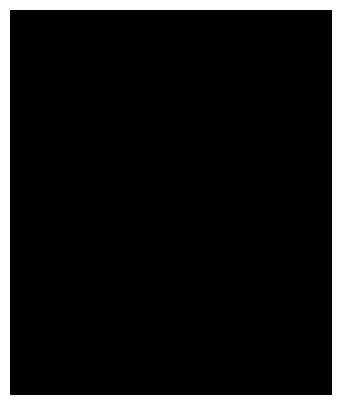

In [ ]:
# N_BITS = 8

# def postprocess(x):
#     x = torch.sigmoid(x)  # Normalize between 0 and 1
#     x = x * 255  # Rescale to 0-255
#     return x.byte()

# def sample(model):
#     with torch.no_grad():
#         if hparams['y_condition']:
#             y = torch.eye(num_classes)
#             y = y.repeat(batch_size // num_classes + 1)
#             y = y[:28, :].to(device)
#         else:
#             y = None

#         z = model(y_onehot=y, temperature=1, reverse=True)  # Generate samples
#         images = postprocess(z)

#     return images.cpu()

# # Sample and visualize
# images = sample(model)
# grid = make_grid(images[:30], nrow=5).permute(1, 2, 0).squeeze()  # Adjust for grayscale

# plt.figure(figsize=(5, 5))
# plt.imshow(grid, cmap='gray')  # Ensure the right colormap for grayscale images
# plt.axis('off')


# Gradient Features

In [3]:
def gradient_features(model, inputs):
    
    # Set the model to evaluation mode
    model = model.to(device).eval()
    inputs = inputs.to(device)

    # Reset gradients
    model.zero_grad()
    # Enable gradient tracking
    inputs.requires_grad = True

    # Forward pass through the model
    outputs = model(inputs)
    # print(f"{outputs= }")
    
    # If the model outputs a tuple (e.g., logits, auxiliary outputs), extract the logits
    if isinstance(outputs, tuple):
        log_likelihoods = outputs[0]  # Assuming the first element is the relevant output (logits or likelihood)
    else:
        log_likelihoods = outputs  # If it's not a tuple, directly use the output
    # print(f"{log_likelihoods= }")
    # Sum the log-likelihoods to compute the total loss
    loss = torch.sum(log_likelihoods)
    # print(f"{loss= }")
    # Backpropagate to compute gradients
    loss.backward()

    # Calculate layer-wise squared L2 norms of gradients and keep track of the number of features
    features_scalar = []
    features = []
    num_features = []
    for param in model.parameters():
        if param.grad is not None:
            # Layer-wise L2 norm of gradients
            squared_layer_norm = torch.norm(param.grad)**2
            features.append(squared_layer_norm)  # Store the layer-wise norm
            features_scalar.append(squared_layer_norm.item())  # Convert to a scalar and store
            num_features.append(param.grad.numel())  # Store the number of features

    return features, num_features, features_scalar


In [7]:
# for i, param in enumerate(model.parameters()):
#     if param.grad is not None and i <= 2:
#         print(param.grad.shape)
#         print(param.grad)
#     # break


# Fit Guassians to Log_features

In [5]:
from torch.utils.data import DataLoader, Subset
import random
# Randomly select 1000 samples from the fit dataset
# num_samples = 1000
batch_size = 5
# random_indices = random.sample(range(len(test_cifar)), num_samples)

# # Create a subset of the fit_dataset using the random indices
# fit_subset = Subset(test_cifar, random_indices)

# # Create a DataLoader for the subset
# fit_loader = DataLoader(fit_subset, batch_size=batch_size, shuffle=False)

# # Define DataLoader for the test set
fit_loader = DataLoader(test_mixed, batch_size=batch_size, shuffle=False)
# fit_loader = DataLoader(test_svhn, batch_size=batch_size, shuffle=False)

# Get a batch of 5 samples from the test DataLoader
# fit_samples, labels = next(iter(fit_loader))  # Retrieve a batch of inputs and labels
# inputs = inputs.to(device)  # Move inputs to the correct device (GPU or CPU)

# Now you can pass the inputs to your gradient_features function
# features, num_gradients_in_layers, features_scalar = gradient_features(model, fit_samples)


In [5]:
# fit_samples.shape

torch.Size([5, 3, 32, 32])

In [6]:

def fit_gaussians_to_log_features(model, fit_loader, device):
    model.eval()  # Set model to evaluation mode

    # Initialize a list to hold log features for each layer
    # Use a list of tensors initialized with empty tensors to accumulate log features
    all_features = None

    # Loop through batches in the fit dataset
    for inputs, _ in tqdm(fit_loader, desc='Fitting Gaussians to log features'):
        inputs = inputs.to(device)

        # Get the gradient features for the batch
        features, _, _ = gradient_features(model, inputs)

        # Take the log of each feature in the batch
        log_features = [torch.log(f + 1e-10) for f in features]  # Add small value to avoid log(0)

        # If all_features is None, initialize it with the first batch's log features
        if all_features is None:
            all_features = [f.unsqueeze(0) for f in log_features]  # Start a new list of tensors
        else:
            # Concatenate the new log features with existing ones for each layer
            for i in range(len(all_features)):
                all_features[i] = torch.cat((all_features[i], log_features[i].unsqueeze(0)), dim=0)

    # Initialize lists to store Gaussian parameters for each layer
    means = []
    variances = []

    # Iterate over layers to calculate mean and variance
    for layer_features in all_features:
        # Compute mean and variance across batches
        layer_mean = torch.mean(layer_features, dim=0)
        layer_variance = torch.var(layer_features, dim=0)

        # Append as tensors to means and variances
        means.append(layer_mean.detach())  # Detach to avoid gradient tracking
        variances.append(layer_variance.detach())

    return means, variances, all_features

# Fit Gaussians to the log of the gradient features
means, variances, all_features = fit_gaussians_to_log_features(model, fit_loader, device)


Fitting Gaussians to log features:   1%|          | 131/12526 [03:36<5:42:11,  1.66s/it]


KeyboardInterrupt: 

# OOD Score

In [8]:

def gaussian_negative_log_likelihood(log_features, means, variances):
    ood_scores = []

    # Iterate over each layer's features, means, and variances
    for layer_features, mu, sigma2 in zip(log_features, means, variances):
        # Ensure mu and sigma2 are tensors and have the correct shape
        mu = mu.to(layer_features.device)
        sigma2 = sigma2.to(layer_features.device)

        # Reshape sigma2 to allow broadcasting
        if sigma2.dim() == 1:
            sigma2 = sigma2.view(1, -1)  # Shape (1, num_features)

        # Compute the negative log-likelihood for the layer
        epsilon = 1e-10
        nll = 0.5 * torch.sum(((layer_features - mu) ** 2) / (sigma2+epsilon) + torch.log(2 * torch.pi * (sigma2+epsilon)), dim=0)
        ood_scores.append(nll)
        # print(f"{nll= }")

    # Sum over all layers to get the final OOD score for each sample
    # sfeatures = torch.stack(ood_scores)
    # print(f"{sfeatures.shape},\n {sfeatures= }")
    # print(f"{ood_scores= }")
    
    return torch.sum(torch.stack(ood_scores))

def ood_score(model, new_samples, means, variances, device):
    # model.to(device)
    model.eval()  # Set model to evaluation mode

    # Compute the gradient features for the new batch
    features, _, _ = gradient_features(model, new_samples)

    # Take the log of each feature in the batch
    log_features = [torch.log(f + 1e-10) for f in features]  # Add small value to avoid log(0)
    # print(f"{log_features= }")

    # Compute OOD score using Gaussian negative log-likelihood
    ood_scores = gaussian_negative_log_likelihood(log_features, means, variances)

    return ood_scores



In [11]:
# TRain on SVHN and test on CIFAR10

# Randomly select 1000 samples from a dataset
model = model.to(device)
num_samples = min(len(test_cifar), len(test_svhn))
# batch_size = 1


# Create a subset of the test_dataset using the random indices
random_indices = random.sample(range(len(test_cifar)), num_samples)
test_subset = Subset(test_cifar, random_indices)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# test_loader = DataLoader(test_svhn, batch_size=batch_size, shuffle=False)

ood_scores_test_samples = []
for test_samples, _ in tqdm(test_loader, desc="Processing test samples"):
    test_samples = test_samples.to(device)
    # Compute the OOD scores for the test samples
    ood_scores_test_samples.append(ood_score(model, test_samples, means, variances, device))

# Save ood_scores_fit_samples
torch.save(ood_scores_test_samples, f'{dataset_output_dir}/parthially_trained_781_ood_scores_test_samples_1_svhn_on_cifar10.pth')
print("Saved parthially_trained_781_ood_scores_test_samples_1_svhn_on_cifar10.pth")


# Define DataLoader for the fit set
random_indices = random.sample(range(len(test_svhn)), num_samples)
test_subset = Subset(test_svhn, random_indices)
fit_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# fit_loader = DataLoader(test_cifar, batch_size=batch_size, shuffle=False)

ood_scores_fit_samples = []
for fit_samples, _ in tqdm(fit_loader, desc="Processing fit samples"):
    fit_samples = fit_samples.to(device)
    # Compute the OOD scores for the fit samples
    ood_scores_fit_samples.append(ood_score(model, fit_samples, means, variances, device))
# Save ood_scores_fit_samples
torch.save(ood_scores_fit_samples, f'{dataset_output_dir}/partially_trained_1144_ood_scores_fit_samples_1_cifar10_from_test_dataset.pth')
print("Saved partially_trained_1144_ood_scores_fit_samples_1_cifar10_from_test_dataset.pth")


Processing fit samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing fit samples: 100%|██████████| 10000/10000 [1:13:52<00:00,  2.26it/s]


Saved partially_trained_1144_ood_scores_fit_samples_1_cifar10_from_test_dataset.pth


In [8]:
# loader = DataLoader(test_cifar, batch_size=5, shuffle=False)
name = fit_loader.dataset.__str__()
name

'Dataset CIFAR10\n    Number of datapoints: 10000\n    Root location: data/CIFAR10\n    Split: Test\n    StandardTransform\nTransform: Compose(\n               ToTensor()\n               <function preprocess at 0x7fefd4418790>\n           )\nTarget transform: <function one_hot_encode at 0x7fefd44188b0>'

In [9]:
# # TRain on CiFar10 and test on SVHN

# # Randomly select 1000 samples from a dataset
# model = model.to(device)
# num_samples = min(len(test_cifar), len(test_svhn))
# # batch_size = 5


# # Create a subset of the fit_dataset using the random indices
# random_indices = random.sample(range(len(test_svhn)), num_samples)
# test_subset = Subset(test_svhn, random_indices)
# test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# # test_loader = DataLoader(test_svhn, batch_size=batch_size, shuffle=False)

# ood_scores_test_samples = []
# for test_samples, _ in tqdm(test_loader, desc="Calculating ood_scores on test samples"):
#     test_samples = test_samples.to(device)
#     # Compute the OOD scores for the test samples
#     ood_scores_test_samples.append(ood_score(model, test_samples, means, variances, device))

# # Save ood_scores_fit_samples
# torch.save(ood_scores_test_samples, 'output/parthially_trained_ood_scores_test_samples_5_svhn_on_cifar10.pth')
# print("Saved parthially_trained_ood_scores_test_samples_5_svhn_on_cifar10.pth")


# # Define DataLoader for the test set
# random_indices = random.sample(range(len(test_cifar)), num_samples)
# test_subset = Subset(test_cifar, random_indices)
# fit_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# # fit_loader = DataLoader(test_cifar, batch_size=batch_size, shuffle=False)

# ood_scores_fit_samples = []
# for fit_samples, _ in tqdm(fit_loader, desc="Calculating ood_scores on fit samples"):
#     fit_samples = fit_samples.to(device)
#     # Compute the OOD scores for the fit samples
#     ood_scores_fit_samples.append(ood_score(model, fit_samples, means, variances, device))
# # Save ood_scores_fit_samples
# torch.save(ood_scores_fit_samples, 'output/partially_trained_ood_scores_fit_samples_5_cifar10_from_test_dataset.pth')
# print("Saved partially_trained_ood_scores_fit_samples_5_cifar10_from_test_dataset.pth")

# # print(f"{ood_scores_test_samples=}")
# # print(f"{ood_scores_fit_samples=}")


Calculating ood_scores on test samples: 100%|██████████| 2000/2000 [54:25<00:00,  1.63s/it] 


Saved parthially_trained_ood_scores_test_samples_5_svhn_on_cifar10.pth


Calculating ood_scores on fit samples: 100%|██████████| 2000/2000 [54:42<00:00,  1.64s/it] 


Saved partially_trained_ood_scores_fit_samples_1_cifar10_from_test_dataset.pth


# Plot OOD_SCORES

In [ ]:
import re
from collections import defaultdict
from os import listdir, path
from utilities.routes import OUTPUT_DIR

# # Example list of filenames
# file_list = [
#     "ood_scores_fit_samples_b1_cifar10_using_checkpoint_781.pth",
#     "ood_scores_fit_samples_b1_cifar10_using_checkpoint_7810.pth",
#     "ood_scores_test_samples_b1_celeba_on_cifar10_using_checkpoint_781.pth",
#     "ood_scores_test_samples_b1_celeba_on_cifar10_using_checkpoint_7810.pth",
#     "ood_scores_test_samples_b1_imagenet32_on_cifar10_using_checkpoint_781.pth",
#     "ood_scores_test_samples_b1_imagenet32_on_cifar10_using_checkpoint_7810.pth",
#     "ood_scores_test_samples_b1_svhn_on_cifar10_using_checkpoint_781.pth",
#     "ood_scores_test_samples_b1_svhn_on_cifar10_using_checkpoint_7810.pth",
# ]

fit_dataset_name = 'cifar10'  # Name of the dataset used for training
model_type = 'glow'  # Type of model used for training
# List the name of checkpoints for each subfolder
data_path = path.join(OUTPUT_DIR, f"{model_type}_{fit_dataset_name}")

def load_ood_scores(file_path):
    """
    Check if the specified file exists and load the data.
    Args:
    - file_path (str): Path to the file to be loaded.

    Returns:
    - ood_scores (list or None): Loaded data if the file exists, None otherwise.
    """
    if path.exists(file_path):
        print(f"File '{file_path}' is loading...")
        ood_scores = torch.load(file_path)
        return ood_scores
    else:
        print(f"File '{file_path}' not found.")
        return None

# Function to extract checkpoint number
def extract_checkpoint(filename):
    match = re.search(r"checkpoint_(\d+)\.pth", filename)
    return int(match.group(1)) if match else 0

# Sort the file list based on the extracted checkpoint number
sorted_files = sorted(data_path, key=extract_checkpoint)

# Group files by checkpoint number using a dictionary
checkpoint_groups = defaultdict(list)
for filename in sorted_files:
    checkpoint = extract_checkpoint(filename)
    checkpoint_groups[checkpoint].append(filename)

# Convert the dictionary values to a list of lists, each containing files with the same checkpoint
grouped_files = list(checkpoint_groups.values())

# Output grouped filenames
for group in grouped_files:
    print("Checkpoint Group:")
    for filename in group:
        ood_scores_fit_samples = load_ood_scores()
        fit_dir = listdir(filename) if (fit_dir.startswith('ood_scores_fit') and fit_dir.endswith('.pth')) else None
        if fit:

        test_checkpoints = [f for f in listdir(filename) if (f.startswith('ood_scores_test') and f.endswith('.pth'))]
        # print("  ", filename)


Checkpoint Group:
   ood_scores_fit_samples_b1_cifar10_using_checkpoint_781.pth
   ood_scores_test_samples_b1_celeba_on_cifar10_using_checkpoint_781.pth
   ood_scores_test_samples_b1_imagenet32_on_cifar10_using_checkpoint_781.pth
   ood_scores_test_samples_b1_svhn_on_cifar10_using_checkpoint_781.pth
Checkpoint Group:
   ood_scores_fit_samples_b1_cifar10_using_checkpoint_7810.pth
   ood_scores_test_samples_b1_celeba_on_cifar10_using_checkpoint_7810.pth
   ood_scores_test_samples_b1_imagenet32_on_cifar10_using_checkpoint_7810.pth
   ood_scores_test_samples_b1_svhn_on_cifar10_using_checkpoint_7810.pth


File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/ood_scores_fit_samples_b5_svhn_using_checkpoint_1144.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/ood_scores_test_samples_b5_celeba_on_svhn_using_checkpoint_1144.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/ood_scores_test_samples_b5_gtsrb_on_svhn_using_checkpoint_1144.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/ood_scores_test_samples_b5_imagenet32_on_svhn_using_checkpoint_1144.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/ood_scores_test_samples_b5_cifar10_on_svhn_using_checkpoint_1144.pth' is loading...


/tmp/ipykernel_1344660/2869204169.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ood_scores = torch.load(file_path)


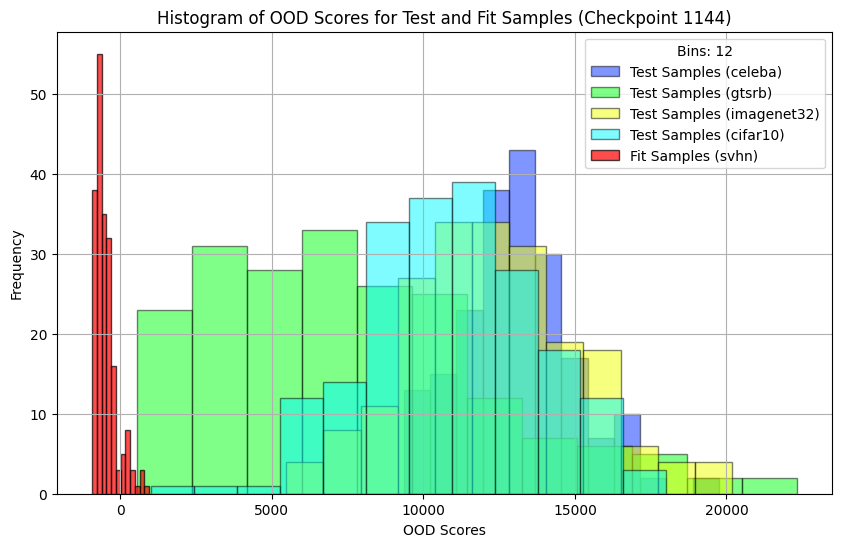

AUROC for celeba against svhn (Checkpoint 1144): 1.0000
Accuracy using best threshold: 0.9975
Confusion Matrix:
[[200   0]
 [  1 199]]
AUROC for gtsrb against svhn (Checkpoint 1144): 0.9998
Accuracy using best threshold: 0.9925
Confusion Matrix:
[[200   0]
 [  3 197]]
AUROC for imagenet32 against svhn (Checkpoint 1144): 1.0000
Accuracy using best threshold: 0.9975
Confusion Matrix:
[[200   0]
 [  1 199]]
AUROC for cifar10 against svhn (Checkpoint 1144): 1.0000
Accuracy using best threshold: 0.9975
Confusion Matrix:
[[200   0]
 [  1 199]]


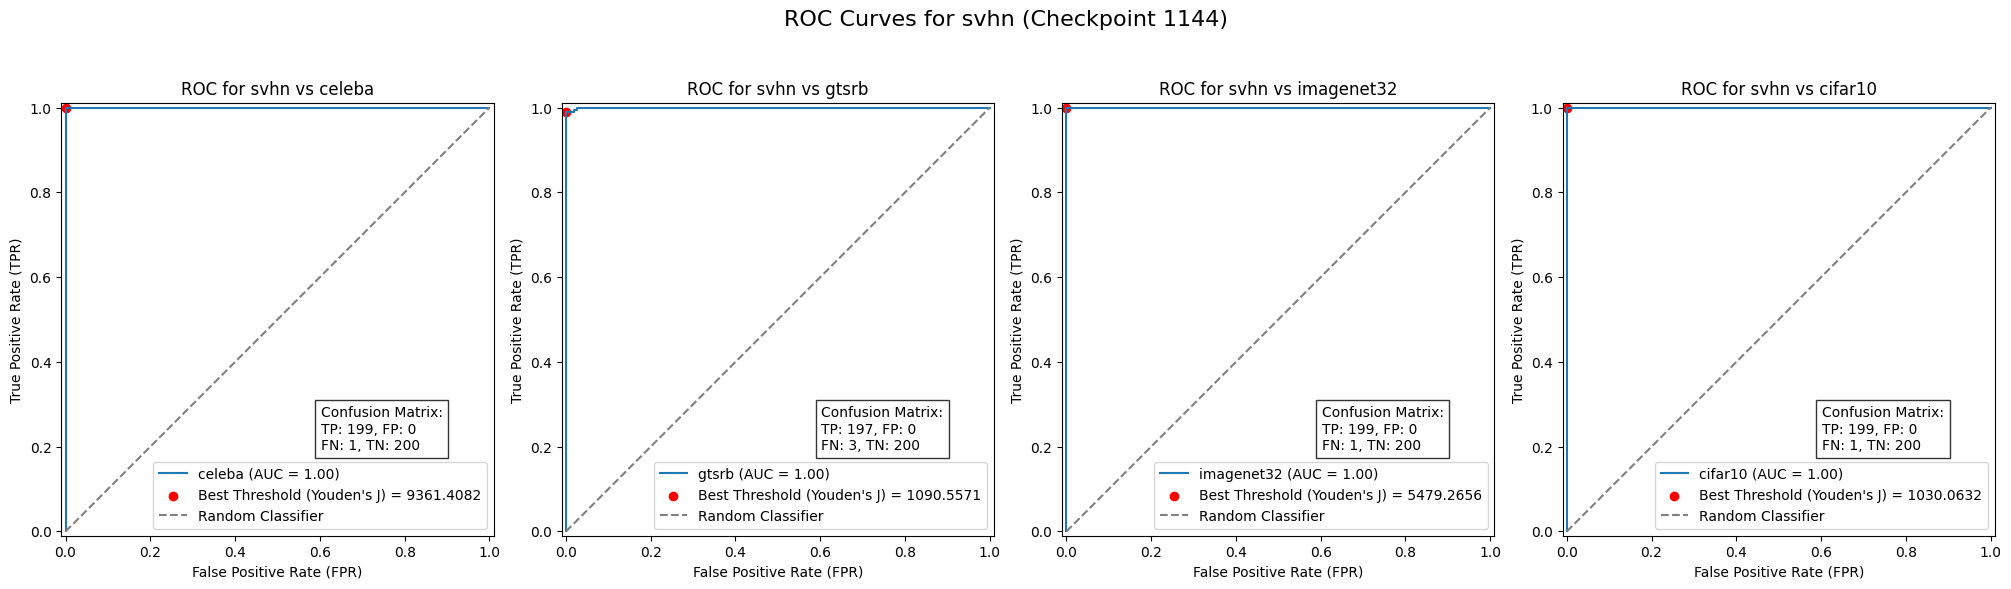

Combined AUROC scores saved to /net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/plots/combined_auroc_scores.csv
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/ood_scores_fit_samples_b5_svhn_using_checkpoint_11440.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/ood_scores_test_samples_b5_celeba_on_svhn_using_checkpoint_11440.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/ood_scores_test_samples_b5_gtsrb_on_svhn_using_checkpoint_11440.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/ood_scores_test_samples_b5_imagenet32_on_svhn_using_checkpoint_11440.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/ood_scores_test_samples_b5_cifar10_on_svhn_using_checkpoint_11440.pth

/tmp/ipykernel_1344660/2869204169.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ood_scores = torch.load(file_path)


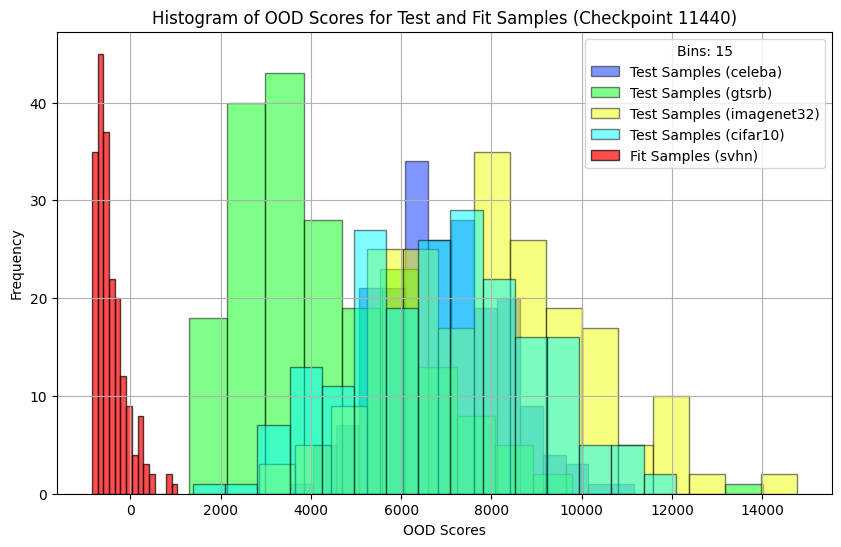

AUROC for celeba against svhn (Checkpoint 11440): 1.0000
Accuracy using best threshold: 0.9975
Confusion Matrix:
[[200   0]
 [  1 199]]
AUROC for gtsrb against svhn (Checkpoint 11440): 1.0000
Accuracy using best threshold: 0.9975
Confusion Matrix:
[[200   0]
 [  1 199]]
AUROC for imagenet32 against svhn (Checkpoint 11440): 1.0000
Accuracy using best threshold: 0.9975
Confusion Matrix:
[[200   0]
 [  1 199]]
AUROC for cifar10 against svhn (Checkpoint 11440): 1.0000
Accuracy using best threshold: 0.9975
Confusion Matrix:
[[200   0]
 [  1 199]]


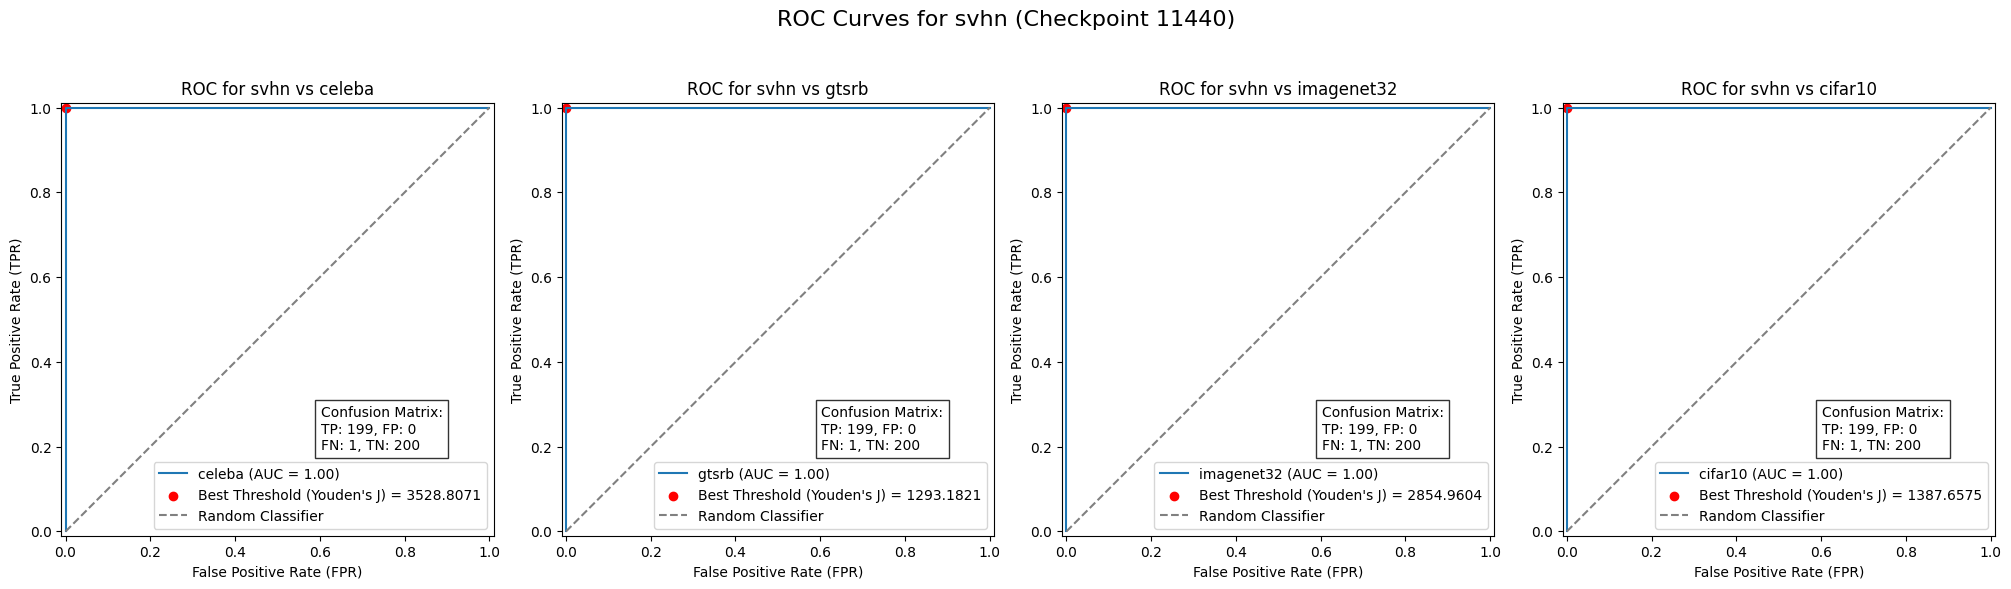

Combined AUROC scores saved to /net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_svhn/5/plots/combined_auroc_scores.csv


In [8]:
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from os import path, listdir, makedirs
from utilities.routes import OUTPUT_DIR
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay



# Function to extract checkpoint, dataset name, and batch size from the filename
def parse_filename(filename):
    """Parse the filename to extract checkpoint, dataset name, and batch size."""
    # Extract checkpoint number
    checkpoint_match = re.search(r"checkpoint_(\d+)\.pth", filename)
    checkpoint = int(checkpoint_match.group(1)) if checkpoint_match else None

    # Extract dataset names and batch size for fit and test samples
    fit_match = re.search(r"ood_scores_fit_samples_b(\d+)_([a-zA-Z0-9]+)_using_checkpoint", filename)
    test_match = re.search(r"ood_scores_test_samples_b(\d+)_([a-zA-Z0-9]+)_on_([a-zA-Z0-9]+)_using_checkpoint", filename)

    if fit_match:
        batch_size = int(fit_match.group(1))
        dataset_name = fit_match.group(2)  
        return 'fit', batch_size, dataset_name, checkpoint
    
    elif test_match:
        batch_size = int(test_match.group(1))
        test_dataset_name = test_match.group(2)  
        fit_dataset_name = test_match.group(3)   
        return 'test', batch_size, test_dataset_name, fit_dataset_name, checkpoint
    
    return None

# Function to group files by checkpoint
def group_files_by_checkpoint(file_path):
    """Group files by checkpoint number"""
    grouped_files = defaultdict(lambda: {'fit': None, 'tests': []})
    
    file_list = [f for f in listdir(file_path) if (f.startswith('ood_scores') and f.endswith('.pth'))]
    for filename in file_list:
        parsed = parse_filename(filename)
        if parsed:
            if parsed[0] == 'fit':  # It's a fit file
                checkpoint = parsed[3]
                grouped_files[checkpoint]['fit'] = filename
            elif parsed[0] == 'test':  # It's a test file
                checkpoint = parsed[4]
                grouped_files[checkpoint]['tests'].append(filename)
    
    # Filter out incomplete groups (i.e., those without both fit and tests)
    return {k: v for k, v in grouped_files.items() if v['fit'] and len(v['tests']) == 4}

# Function to read OOD scores from a file
def read_ood_scores(file_path):
    """Read OOD scores from a file"""
    # file_path = path.join(data_path, file_name)
    if path.exists(file_path):
        print(f"File '{file_path}' is loading...")
        ood_scores = torch.load(file_path)
        return torch.cat([score.unsqueeze(0) for score in ood_scores], dim=0).cpu().detach().numpy()
    else:
        print(f"File '{file_path}' not found.")
        return None


# Function to plot histograms for fit and test scores
def plot_histogram(fit_scores, test_scores_dict, fit_dataset_name, checkpoint, output_dir):
    """Plot histograms for fit and test scores"""
    # Calculate optimal bins
    test_scores_list = [scores for scores in test_scores_dict.values()]
    bins = best_bin_size(fit_scores, test_scores_list)
    
    plt.figure(figsize=(10, 6))
    
    # Define a more distinctive list of colors for the datasets
    colors = ['#002CFF', '#00FF11', '#F0FF00', '#00FAFF'] # Blue, Green, Yellow, Cyan
    color_cycle = iter(colors)
    
    # Plot histogram for each test dataset with distinct colors
    for test_name, scores in test_scores_dict.items():
        plt.hist(scores, bins=bins, alpha=0.5, label=f'Test Samples ({test_name})', color=next(color_cycle), edgecolor='black')

    # Plot histogram for fit samples
    plt.hist(fit_scores, bins=bins, alpha=0.7, label=f'Fit Samples ({fit_dataset_name})', color='#FF0000', edgecolor='black') # Red
    
    # Add labels and title
    plt.xlabel('OOD Scores')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of OOD Scores for Test and Fit Samples (Checkpoint {checkpoint})')
    plt.legend(title=f'Bins: {bins}')
    plt.grid(True)

    # Save the plot
    plot_filename = f"histogram_{fit_dataset_name}_checkpoint_{checkpoint}.png"
    plt.savefig(path.join(output_dir, plot_filename))
    
    # Show the plot
    plt.show()

# Function to calculate the optimal bin size using the Freedman-Diaconis rule
def best_bin_size(fit_scores, test_scores_list):
    """Calculate the optimal bin size using the Freedman-Diaconis rule"""
    all_scores = np.concatenate([fit_scores, *test_scores_list])
    q25, q75 = np.percentile(all_scores, [25, 75])
    bin_width = 2 * (q75 - q25) * len(all_scores) ** (-1/3)
    bins = int((all_scores.max() - all_scores.min()) / bin_width)
    return max(bins, 10)  # Ensure a minimum of 10 bins

# Main function to process files, read scores, and plot
def process_and_plot(file_path):
    """Process files, read scores, and plot histograms and AUROC"""
    output_plot_dir = path.join(file_path, "plots")

    # Create output directory if it doesn't exist
    makedirs(output_plot_dir, exist_ok=True)

    # Group files by checkpoint
    grouped_files = group_files_by_checkpoint(file_path)
    
    for checkpoint, files in grouped_files.items():
        # Read fit scores
        fit_filename = files['fit']
        fit_info = parse_filename(fit_filename)
        fit_dataset_name = fit_info[2]
        f_path = path.join(file_path, fit_filename)
        fit_scores = read_ood_scores(f_path)

        # Read test scores for each test dataset in this checkpoint group
        test_scores_dict = {}
        # test_scores_list = []
        for test_filename in files['tests']:
            test_info = parse_filename(test_filename)
            test_dataset_name = test_info[2]
            f_path = path.join(file_path, test_filename)
            test_scores = read_ood_scores(f_path)
            test_scores_dict[test_dataset_name] = test_scores
            # test_scores_list.append(test_scores)


        # Plot histograms
        plot_histogram(fit_scores, test_scores_dict, fit_dataset_name, checkpoint, output_plot_dir)

        # Plot AUROC
        auroc_df = plot_auroc_subplot(fit_scores, test_scores_dict, fit_dataset_name, checkpoint, output_plot_dir)
        save_auroc_csv(auroc_df, output_plot_dir)


def plot_auroc_subplot(fit_scores, test_scores_dict, fit_dataset_name, checkpoint, output_dir):
    """Calculate and plot AUROC for fit against each test dataset using subplots, returning a DataFrame with AUROC scores."""
    
    # Define the column name based on fit_dataset_name and checkpoint
    column_name = f"{fit_dataset_name}_checkpoint_{checkpoint}"
    
    # Dictionary to store current checkpoint AUROC scores
    auroc_scores = {}

    # Define the number of test datasets for subplots
    num_tests = len(test_scores_dict)
    fig, axs = plt.subplots(1, num_tests, figsize=(5 * num_tests, 6), constrained_layout=True)
    
    # Ensure axs is iterable even when there's only one subplot
    if num_tests == 1:
        axs = [axs]
    
    for ax, (test_name, test_scores) in zip(axs, test_scores_dict.items()):
        # Create labels: 0 for fit samples (in-distribution), 1 for test samples (out-of-distribution)
        labels_fit = np.zeros_like(fit_scores)  # 0 for in-distribution
        labels_test = np.ones_like(test_scores)  # 1 for out-of-distribution

        # Concatenate scores and labels
        all_scores = np.concatenate([fit_scores, test_scores])
        all_labels = np.concatenate([labels_fit, labels_test])

        # Compute ROC curve and AUROC
        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        auroc = roc_auc_score(all_labels, all_scores)
        
        # Store the AUROC score in the dictionary
        auroc_scores[test_name] = auroc
        
        print(f"AUROC for {test_name} against {fit_dataset_name} (Checkpoint {checkpoint}): {auroc:.4f}")

        # Compute Youden's J statistic to find the best threshold
        J_scores = tpr - fpr
        best_threshold_index = np.argmax(J_scores)
        best_threshold = thresholds[best_threshold_index]

        # Evaluate using the best threshold
        predictions = (all_scores > best_threshold).astype(int)
        accuracy = accuracy_score(all_labels, predictions)
        conf_matrix = confusion_matrix(all_labels, predictions)
        conf_matrix_text = f"Confusion Matrix:\nTP: {conf_matrix[1, 1]}, FP: {conf_matrix[0, 1]}\nFN: {conf_matrix[1, 0]}, TN: {conf_matrix[0, 0]}"

        print(f"Accuracy using best threshold: {accuracy:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")

        # Plot ROC curve using RocCurveDisplay
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auroc, estimator_name=test_name)
        display.plot(ax=ax)
        
        # Highlight the best threshold on the plot
        ax.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='#FF0000', 
                   label=f"Best Threshold (Youden's J) = {best_threshold:.4f}")
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
        
        # Set labels, title, and legend
        ax.set_title(f"ROC for {fit_dataset_name} vs {test_name}")
        ax.set_xlabel("False Positive Rate (FPR)")
        ax.set_ylabel("True Positive Rate (TPR)")
        ax.legend(loc='lower right')
        
        # Display the confusion matrix text
        ax.text(0.6, 0.2, conf_matrix_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8), transform=ax.transAxes)
    
    # Set the main title for the entire figure
    fig.suptitle(f"ROC Curves for {fit_dataset_name} (Checkpoint {checkpoint})", fontsize=16)
    
    # Save the entire figure
    plot_filename = f'roc_curves_{fit_dataset_name}_checkpoint_{checkpoint}.png'
    plt.savefig(path.join(output_dir, plot_filename))
    plt.show()

    # Convert auroc_scores to a DataFrame with one column for the current checkpoint
    checkpoint_df = pd.DataFrame.from_dict(auroc_scores, orient='index', columns=[column_name])

    return checkpoint_df

# def plot_auroc(fit_scores, test_scores_dict, fit_dataset_name, checkpoint, output_dir):
#     """Calculate and plot AUROC for fit against each test dataset, returning a DataFrame with AUROC scores."""
    
#     # Define the column name based on fit_dataset_name and checkpoint
#     column_name = f"{fit_dataset_name}_checkpoint_{checkpoint}"
    
#     # Dictionary to store current checkpoint AUROC scores
#     auroc_scores = {}

#     for test_name, test_scores in test_scores_dict.items():
#         # Create labels: 0 for fit samples (in-distribution), 1 for test samples (out-of-distribution)
#         labels_fit = np.zeros_like(fit_scores)  # 0 for in-distribution
#         labels_test = np.ones_like(test_scores)  # 1 for out-of-distribution

#         # Concatenate scores and labels
#         all_scores = np.concatenate([fit_scores, test_scores])
#         all_labels = np.concatenate([labels_fit, labels_test])

#         # Step 1: Compute ROC curve and AUROC
#         fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
#         auroc = roc_auc_score(all_labels, all_scores)
        
#         # Store the AUROC score in the dictionary
#         auroc_scores[test_name] = auroc
        
#         print(f"AUROC for {test_name} against {fit_dataset_name} (Checkpoint {checkpoint}): {auroc:.4f}")

#         # Step 2: Compute Youden's J statistic to find the best threshold
#         J_scores = tpr - fpr  # Youden's J statistic
#         best_threshold_index = np.argmax(J_scores)  # Index of the best threshold
#         best_threshold = thresholds[best_threshold_index]

#         # Step 3: Evaluate using the best threshold
#         predictions = (all_scores > best_threshold).astype(int)  # Apply the best threshold
#         accuracy = accuracy_score(all_labels, predictions)
#         conf_matrix = confusion_matrix(all_labels, predictions)
#         conf_matrix_text = f"Confusion Matrix:\nTP: {conf_matrix[1, 1]}, FP: {conf_matrix[0, 1]}\nFN: {conf_matrix[1, 0]}, TN: {conf_matrix[0, 0]}"

#         print(f"Accuracy using best threshold: {accuracy:.4f}")
#         print(f"Confusion Matrix:\n{conf_matrix}")

#         # Step 4: Plot ROC curve
#         plt.figure(figsize=(8, 6))
#         plt.text(0.6, 0.2, conf_matrix_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8), transform=plt.gca().transAxes)
#         plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {auroc:.4f})")
#         plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='#FF0000', label=f"Best Threshold (Youden's J) = {best_threshold:.4f}")
#         plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
#         plt.xlabel("False Positive Rate (FPR)")
#         plt.ylabel("True Positive Rate (TPR)")
#         plt.title(f"Receiver Operating Characteristic (ROC) Curve for {fit_dataset_name} vs {test_name} (Checkpoint {checkpoint})")
#         plt.legend()
#         plt.grid(True)
        
#         # Save the plot
#         plot_filename = f'roc_curve_{fit_dataset_name}_{test_name}_checkpoint_{checkpoint}.png'
#         plt.savefig(path.join(output_dir, plot_filename))
#         plt.show()
    
#     # Convert auroc_scores to a DataFrame with one column for the current checkpoint
#     checkpoint_df = pd.DataFrame.from_dict(auroc_scores, orient='index', columns=[column_name])

#     return checkpoint_df


def save_auroc_csv(auroc_df, output_dir):
    """Save the accumulated AUROC DataFrame to CSV without overwriting previous data."""
    auroc_csv_filename = 'combined_auroc_scores.csv'
    output_path = path.join(output_dir, auroc_csv_filename)
    
    # If the file exists, load the existing data and concatenate
    if path.exists(output_path):
        existing_df = pd.read_csv(output_path, index_col=0)
        for column in auroc_df.columns:
            if column in existing_df.columns:
                existing_df[column] = auroc_df[column]
            else:
                existing_df = pd.concat([existing_df, auroc_df[[column]]], axis=1)
        auroc_df = existing_df
    
    # Save the combined DataFrame
    auroc_df.to_csv(output_path)
    print(f"Combined AUROC scores saved to {output_path}")


fit_dataset_name = 'svhn'  # Name of the dataset used for training
model_type = 'glow'  # Type of model used for training
ood_batch_size = "5"  # Checkpoint number for the model
# List the name of checkpoints for each subfolder
data_path = path.join(OUTPUT_DIR, f"{model_type}_{fit_dataset_name}")
data_path = path.join(data_path, ood_batch_size)
output_plot_dir = path.join(data_path, "plots")

# Create output directory if it doesn't exist
makedirs(output_plot_dir, exist_ok=True)

# Call the main function to process and plot
process_and_plot(data_path)


In [ ]:
from os import listdir, path
from utilities.routes import OUTPUT_DIR
def load_ood_scores(file_path):
    """
    Check if the specified file exists and load the data.
    Args:
    - file_path (str): Path to the file to be loaded.

    Returns:
    - ood_scores (list or None): Loaded data if the file exists, None otherwise.
    """
    if path.exists(file_path):
        print(f"File '{file_path}' is loading...")
        ood_scores = torch.load(file_path)
        return ood_scores
    else:
        print(f"File '{file_path}' not found.")
        return None
    


fit_dataset_name = 'cifar10'  # Name of the dataset used for training
model_type = 'glow'  # Type of model used for training
# List the name of checkpoints for each subfolder
data_path = path.join(OUTPUT_DIR, f"{model_type}_{fit_dataset_name}")
fit_checkpoints = [f for f in listdir(data_path) if (f.startswith('ood_scores_fit') and f.endswith('.pth'))]
test_checkpoints = [f for f in listdir(data_path) if (f.startswith('ood_scores_test') and f.endswith('.pth'))]

# Load ood_scores_fit_samples
ood_scores_fit_samples = load_ood_scores() # ood_scores_fit_samples_cifar10_from_test_dataset  ood_scores_fit_samples_svhn_from_test_dataset
# Load ood_scores_test_samples
ood_scores_test_samples = load_ood_scores(f'{dataset_output_dir}/parthially_trained_286000_ood_scores_test_samples_1_cifar10_on_svhn.pth') # ood_scores_test_samples_svhn_on_cifar10 ood_scores_test_samples_cifar10_on_svhn


File 'output/partially_trained_286000_ood_scores_fit_samples_1_svhn_from_test_dataset.pth' is loading...


/tmp/ipykernel_640242/733058708.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ood_scores = torch.load(file_path)


File 'output/parthially_trained_286000_ood_scores_test_samples_1_cifar10_on_svhn.pth' is loading...


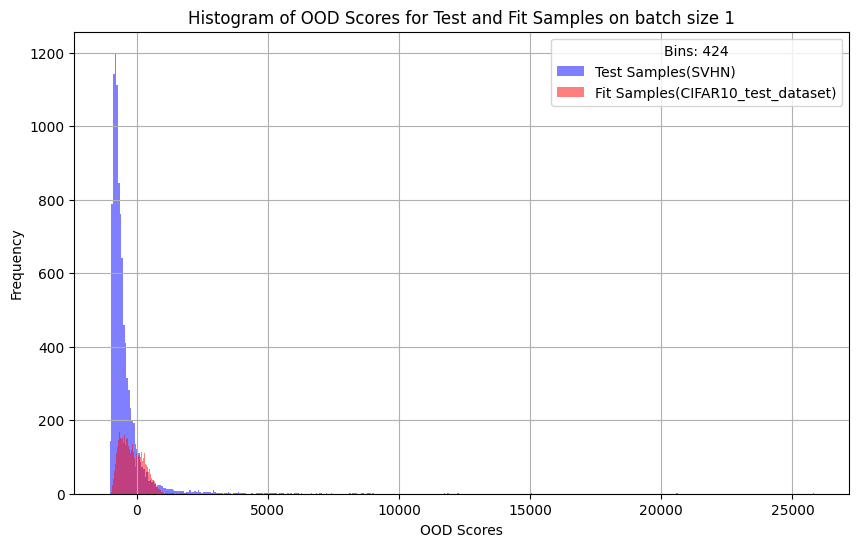

In [12]:

# Convert the list of OOD score tensors into a single tensor (unsqueeze to make 1D if necessary)
ood_scores_test_sample = torch.cat([score.unsqueeze(0) for score in ood_scores_test_samples], dim=0).cpu().detach().numpy()
ood_scores_fit_sample = torch.cat([score.unsqueeze(0) for score in ood_scores_fit_samples], dim=0).cpu().detach().numpy()

# Determine the number of bins using the Freedman-Diaconis rule for better clarity
q25, q75 = np.percentile(np.concatenate([ood_scores_test_sample, ood_scores_fit_sample]), [25, 75])
bin_width = 2 * (q75 - q25) * len(ood_scores_test_sample) ** (-1/3)
bins = int((ood_scores_test_sample.max() - ood_scores_test_sample.min()) / bin_width)

# if bins < 10:
#     bins = 10  # Set a minimum number of bins for better clarity

# Plot the histograms of both OOD scores with fixed-size bins
plt.figure(figsize=(10, 6))

# Plot for test samples
plt.hist(ood_scores_test_sample, bins=bins, alpha=0.5, label=f'Test Samples(SVHN)', color='blue')

# Plot for fit samples
plt.hist(ood_scores_fit_sample, bins=bins, alpha=0.5, label='Fit Samples(CIFAR10_test_dataset)', color='red')

# Add labels and title
plt.xlabel('OOD Scores')
plt.ylabel('Frequency')
plt.title('Histogram of OOD Scores for Test and Fit Samples on batch size 1')

# Add legend
plt.legend(title=f'Bins: {bins}')
plt.grid(True)
# Save the plot
plt.savefig(f'{dataset_output_dir}/(Partially_trained_781)histogram_cifar10_svhn_10k_1s_test_ds.png')
# Show the plot
plt.show()



In [22]:
bin_width

10403.191534178794

AUROC: 0.2476
Best threshold based on Youden's J statistic: 961.3206
Accuracy using best threshold: 0.5127
Confusion Matrix:
[[9907   93]
 [9653  347]]


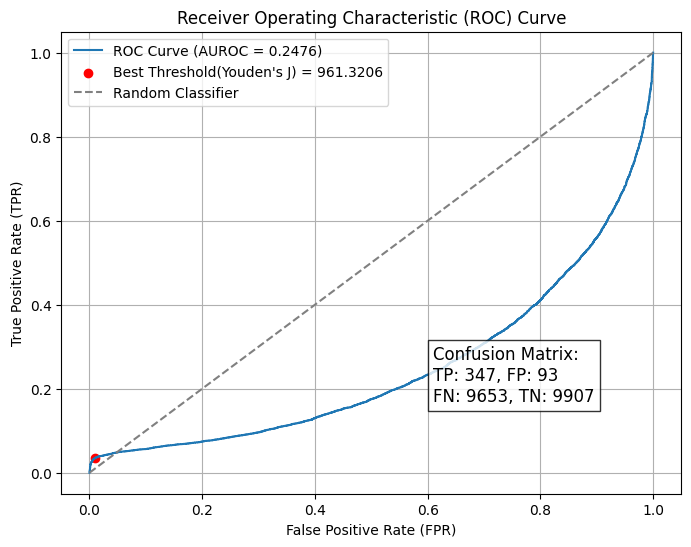

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# Labels: 0 for fit_samples (in-distribution), 1 for test_samples (out-of-distribution)
labels_fit = np.zeros_like(ood_scores_fit_sample)  # 0 for in-distribution
labels_test = np.ones_like(ood_scores_test_sample)  # 1 for out-of-distribution

# Concatenate scores and labels
all_scores = np.concatenate([ood_scores_fit_sample, ood_scores_test_sample])
all_labels = np.concatenate([labels_fit, labels_test])

# Step 1: Compute ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
auroc = roc_auc_score(all_labels, all_scores)
print(f"AUROC: {auroc:.4f}")

# Step 2: Compute Youden's J statistic to find the best threshold
J_scores = tpr - fpr  # Youden's J statistic
best_threshold_index = np.argmax(J_scores)  # Index of the best threshold
best_threshold = thresholds[best_threshold_index]

print(f"Best threshold based on Youden's J statistic: {best_threshold:.4f}")

# Step 3: Evaluate using the best threshold
predictions = (all_scores > best_threshold).astype(int)  # Apply the best threshold
accuracy = accuracy_score(all_labels, predictions)
conf_matrix = confusion_matrix(all_labels, predictions)
conf_matrix_text = f"Confusion Matrix:\nTP: {conf_matrix[1, 1]}, FP: {conf_matrix[0, 1]}\nFN: {conf_matrix[1, 0]}, TN: {conf_matrix[0, 0]}"

print(f"Accuracy using best threshold: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.text(0.6, 0.2, conf_matrix_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8), transform=plt.gca().transAxes)
plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {auroc:.4f})")
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f"Best Threshold(Youden's J) = {best_threshold:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.savefig(f'{dataset_output_dir}/(Partially_trained_781)auroc_cifar10_svhn_10k_1s_test_ds.png')
plt.show()

# NOTE: As the number of samples in cifar10 is only 10000, compared to 26032 in SVHN, the AUROC of cifar10 is not very close to the paper,
#  but the one from SVHN is better from the paper. training on CIFAR10 and testing on SVHN uses the same number for both training and fitting.
# However, for SVHN we train on 26032 and test on 10000, which results to better AUROC than the paper. 
# NOTE: we have to increase the number of samples in train dataset or use a f=very small number of fit samples to get a better AUROC

In [18]:
print(f"{thresholds = }")
print(f"{fpr = }")
print(f"{tpr = }")
print(f"{predictions = }")

thresholds = array([          inf, 6.0478600e+11, 6.0478593e+11, 6.0478587e+11],
      dtype=float32)
fpr = array([0.00e+00, 5.00e-04, 1.25e-02, 1.00e+00])
tpr = array([0.000e+00, 5.000e-04, 9.745e-01, 1.000e+00])
predictions = array([0, 0, 0, ..., 0, 0, 0])


# Plots of Means and Variances

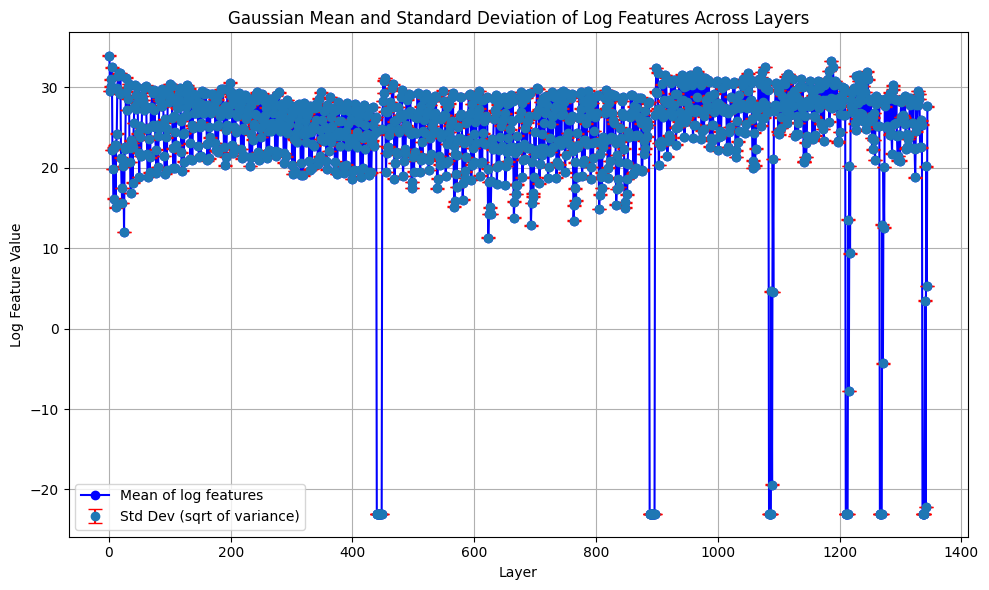

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gaussians(means, variances, layer_labels=None):
    """
    Plots the Gaussian mean and variance for each layer's log features.
    
    Args:
    - means: List of mean values for each layer.
    - variances: List of variance values for each layer.
    - layer_labels: List of layer labels or indices. Optional.
    """
    num_layers = len(means)
    layers = np.arange(1, num_layers + 1) if layer_labels is None else layer_labels

    # Convert variances to standard deviations
    std_devs = [np.sqrt(var) for var in variances]

    # Plot the means and standard deviations
    plt.figure(figsize=(10, 6))

    # Plot the mean of log features for each layer
    plt.plot(layers, means, label='Mean of log features', color='b', marker='o')

    # Plot the variance (as standard deviation) of log features for each layer
    plt.errorbar(layers, means, yerr=std_devs, fmt='o', ecolor='r', capsize=5, label='Std Dev (sqrt of variance)')

    # Labels and title
    plt.xlabel("Layer")
    plt.ylabel("Log Feature Value")
    plt.title("Gaussian Mean and Standard Deviation of Log Features Across Layers")
    plt.legend()

    # Optionally, set layer indices as x-ticks
    if layer_labels:
        plt.xticks(layers, layer_labels, rotation=45)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume 'means' and 'variances' are already computed from the previous steps
plot_gaussians(means, variances)


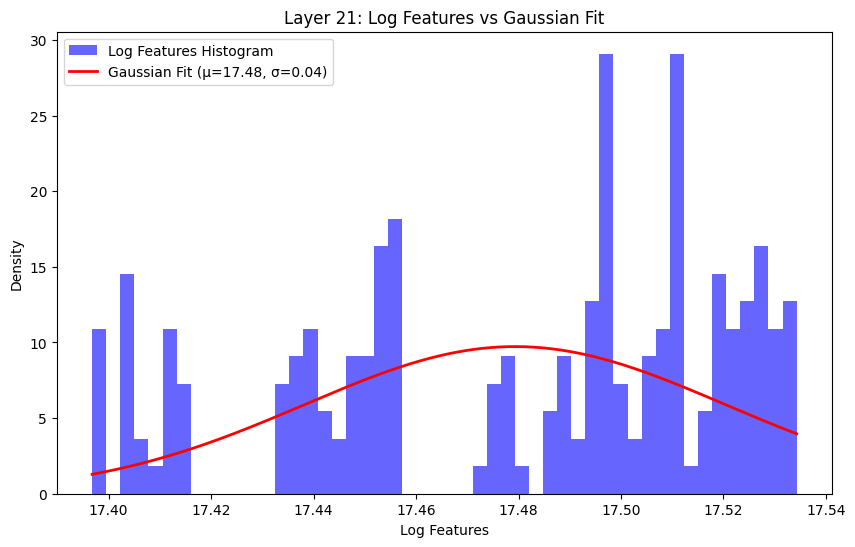

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_gaussian_with_histogram(log_features, means, variances, layer_idx):
    """
    Plot histogram of log features with the fitted Gaussian overlaid.
    
    Parameters:
        log_features (Tensor): Log-transformed features for a specific layer.
        means (list): Mean of the Gaussian for each layer.
        variances (list): Variance of the Gaussian for each layer.
        layer_idx (int): Index of the layer to plot.
    """
    log_features_np = log_features.cpu().numpy().flatten()  # Convert to NumPy array and flatten for plotting
    
    # Compute the Gaussian curve based on the mean and variance
    mu = means[layer_idx]
    sigma = np.sqrt(variances[layer_idx])
    
    # Define the range for plotting the Gaussian curve
    x_min = np.min(log_features_np)
    x_max = np.max(log_features_np)
    x_range = np.linspace(x_min, x_max, 1000)
    gaussian_curve = norm.pdf(x_range, mu, sigma)

    # Create the histogram for the log features
    plt.figure(figsize=(10, 6))
    plt.hist(log_features_np, bins=50, density=True, alpha=0.6, color='blue', label='Log Features Histogram')
    
    # Plot the Gaussian curve
    plt.plot(x_range, gaussian_curve, 'r-', label=f'Gaussian Fit (μ={mu:.2f}, σ={sigma:.2f})', lw=2)

    # Labels and title
    plt.xlabel('Log Features')
    plt.ylabel('Density')
    plt.title(f'Layer {layer_idx + 1}: Log Features vs Gaussian Fit')
    plt.legend()
    
    # Show the plot
    plt.show()

# Example usage (assuming log_features, means, and variances are already computed):

# Layer index to plot (e.g., 0 for the first layer)
layer_idx = 20

# Plot the histogram and Gaussian fit for layer 0
plot_gaussian_with_histogram(all_features[layer_idx], means, variances, layer_idx)


In [57]:
all_features[20]

tensor([17.3973, 17.3971, 17.3968, 17.3970, 17.3973, 17.3972, 17.4048, 17.4044,
        17.4038, 17.4045, 17.4045, 17.4038, 17.4040, 17.4029, 17.4063, 17.4061,
        17.4093, 17.4115, 17.4132, 17.4127, 17.4128, 17.4126, 17.4141, 17.4129,
        17.4135, 17.4140, 17.4147, 17.4344, 17.4334, 17.4333, 17.4341, 17.4354,
        17.4368, 17.4369, 17.4367, 17.4366, 17.4389, 17.4395, 17.4393, 17.4402,
        17.4417, 17.4409, 17.4399, 17.4407, 17.4408, 17.4439, 17.4478, 17.4462,
        17.4465, 17.4469, 17.4484, 17.4501, 17.4501, 17.4511, 17.4516, 17.4528,
        17.4546, 17.4512, 17.4481, 17.4540, 17.4541, 17.4542, 17.4540, 17.4542,
        17.4539, 17.4544, 17.4545, 17.4560, 17.4562, 17.4562, 17.4561, 17.4561,
        17.4552, 17.4558, 17.4559, 17.4560, 17.4728, 17.4749, 17.4749, 17.4748,
        17.4746, 17.4767, 17.4767, 17.4768, 17.4772, 17.4775, 17.4801, 17.4863,
        17.4866, 17.4868, 17.4897, 17.4896, 17.4898, 17.4894, 17.4889, 17.4944,
        17.4927, 17.4926, 17.4932, 17.49

# Ploting

In [ ]:
# Consolidate the output of the AUROC scores into a single CSV file

import os
import pandas as pd

def consolidate_csv_files(input_folder, output_file):
    """
    Reads all CSV files across subfolders, consolidates their values by
    common cells, and writes the result to a new CSV file.
    """
    consolidated_data = pd.DataFrame()  # Initialize an empty DataFrame

    # Iterate over all subfolders
    for folder_name in os.listdir(input_folder):
        folder_path = os.path.join(input_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue
        
        # Iterate over all CSV files in the subfolder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            if os.path.isfile(file_path) and file_name.startswith('combined_auroc_features'):
                df = pd.read_csv(file_path, index_col=0)  # Read the CSV file
                b_size = file_name.split('_')[-1]
                # Initialize columns if `consolidated_data` is empty
                if consolidated_data.empty:
                    consolidated_data = pd.DataFrame(index=df.index, columns=f"{b_size}_" + df.columns)
                    # Initialize cells with empty lists
                    consolidated_data = consolidated_data.applymap(lambda _: [])
                
                # Ensure all rows and columns from `df` exist in `consolidated_data`
                for row in df.index:
                    if row not in consolidated_data.index:
                        consolidated_data.loc[row] = [None] * len(consolidated_data.columns)
                
                for col in df.columns:
                    if f"{b_size}_" + col not in consolidated_data.columns:
                        consolidated_data[f"{b_size}_" + col] = [None] * len(consolidated_data.index)
                
                # Append the values to the corresponding cells
                for row in df.index:
                    for col in df.columns:
                        value = df.at[row, col]
                        if not isinstance(consolidated_data.at[row, f"{b_size}_" + col], list):
                            consolidated_data.at[row, f"{b_size}_" + col] = [value]
                        else:
                            consolidated_data.at[row, f"{b_size}_" + col].append(value)
    
    # Convert lists to comma-separated strings
    consolidated_data = consolidated_data.applymap(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else x)

    # Write the consolidated data to a new CSV file
    consolidated_data.to_csv(output_file)

# Specify the input folder and output file path
input_folder = "AUROC"
output_file = "consolidated_output.csv"

# Run the function
consolidate_csv_files(input_folder, output_file)


/tmp/ipykernel_445310/3738960187.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  consolidated_data = consolidated_data.applymap(lambda _: [])
/tmp/ipykernel_445310/3738960187.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  consolidated_data[f"{b_size}_" + col] = [None] * len(consolidated_data.index)
/tmp/ipykernel_445310/3738960187.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  consolidated_data[f"{b_size}_" + col] = [None] * len(consolidated_data.index)
/tmp/ipykernel_445310

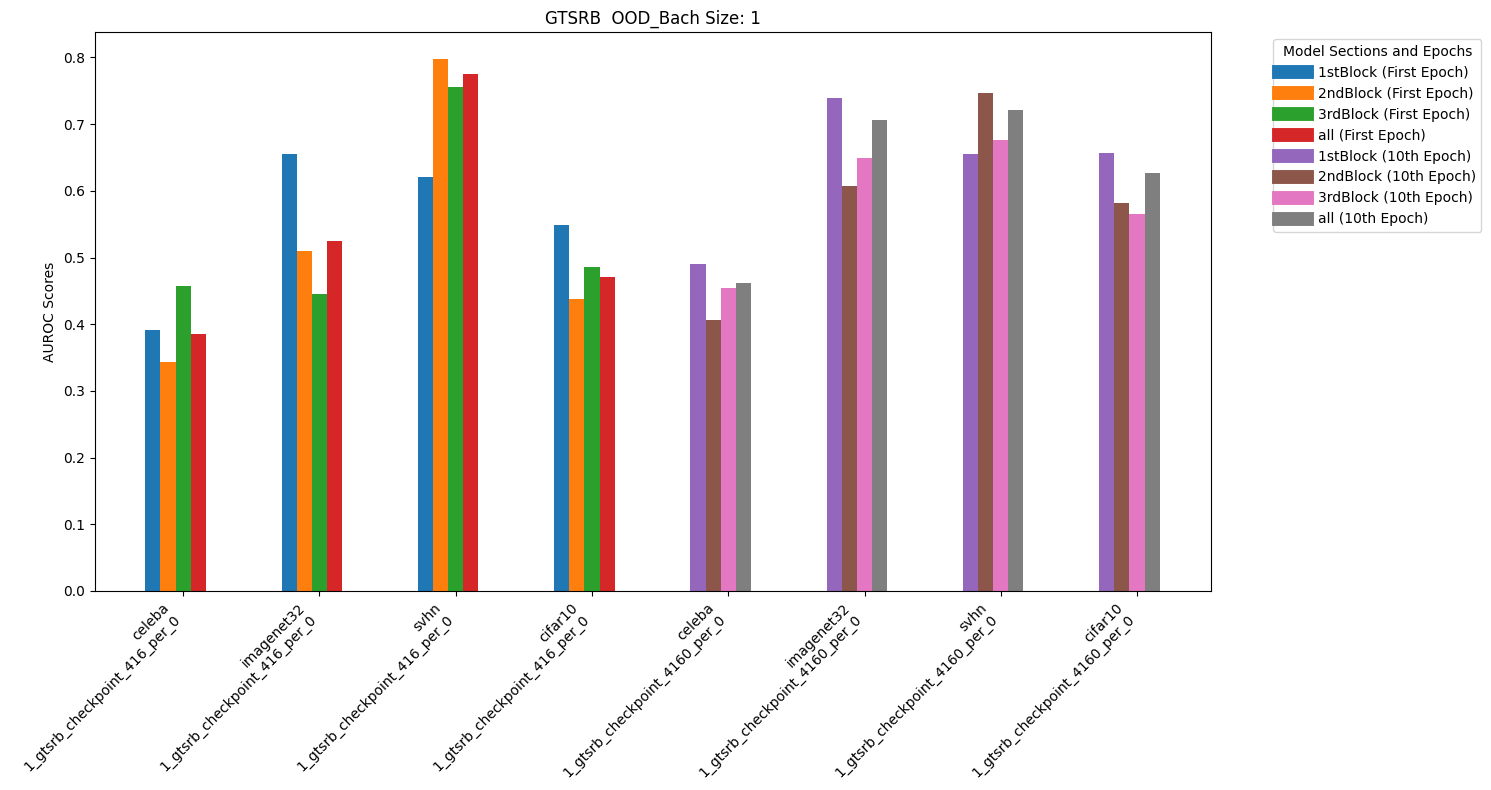

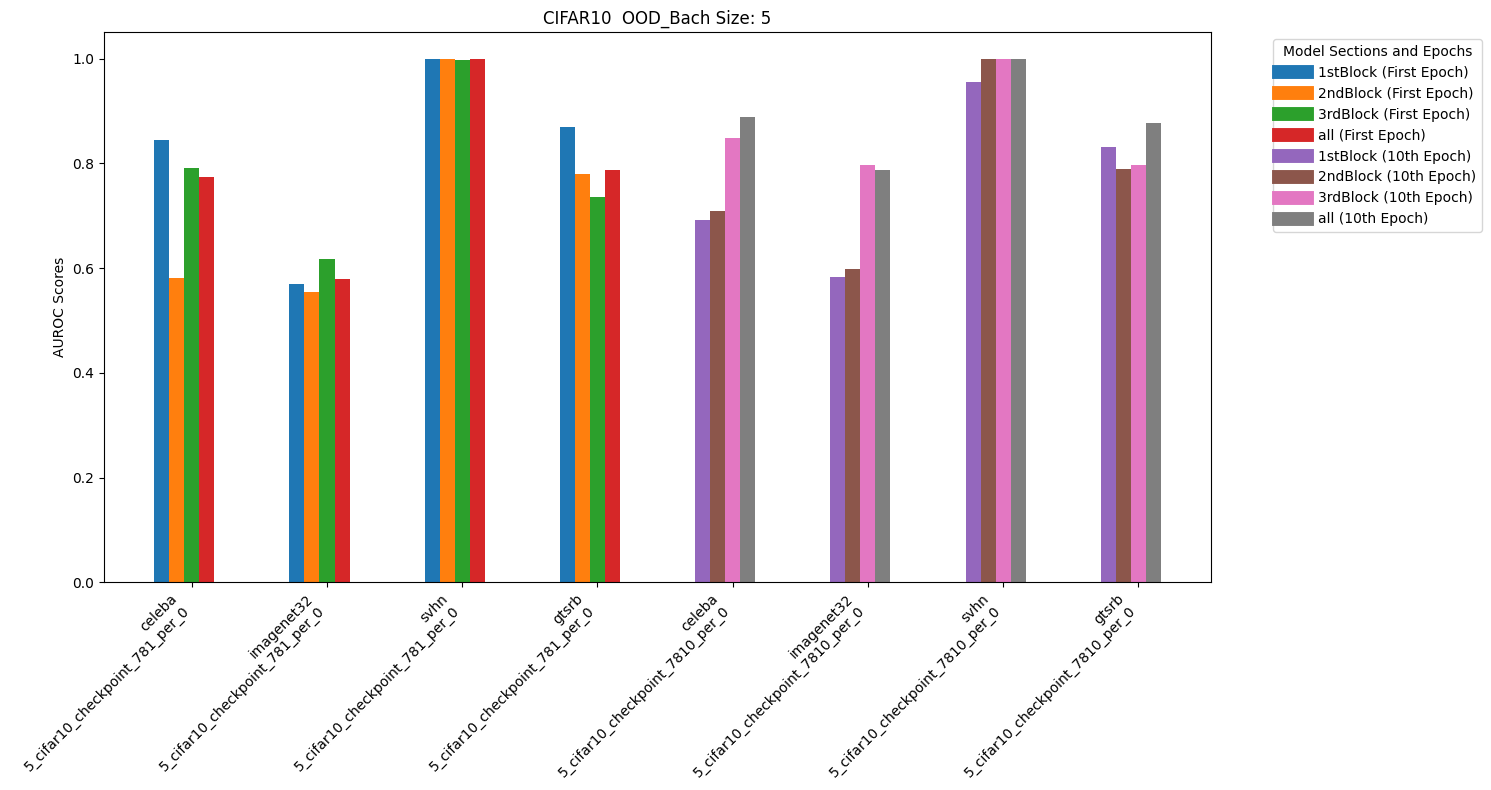

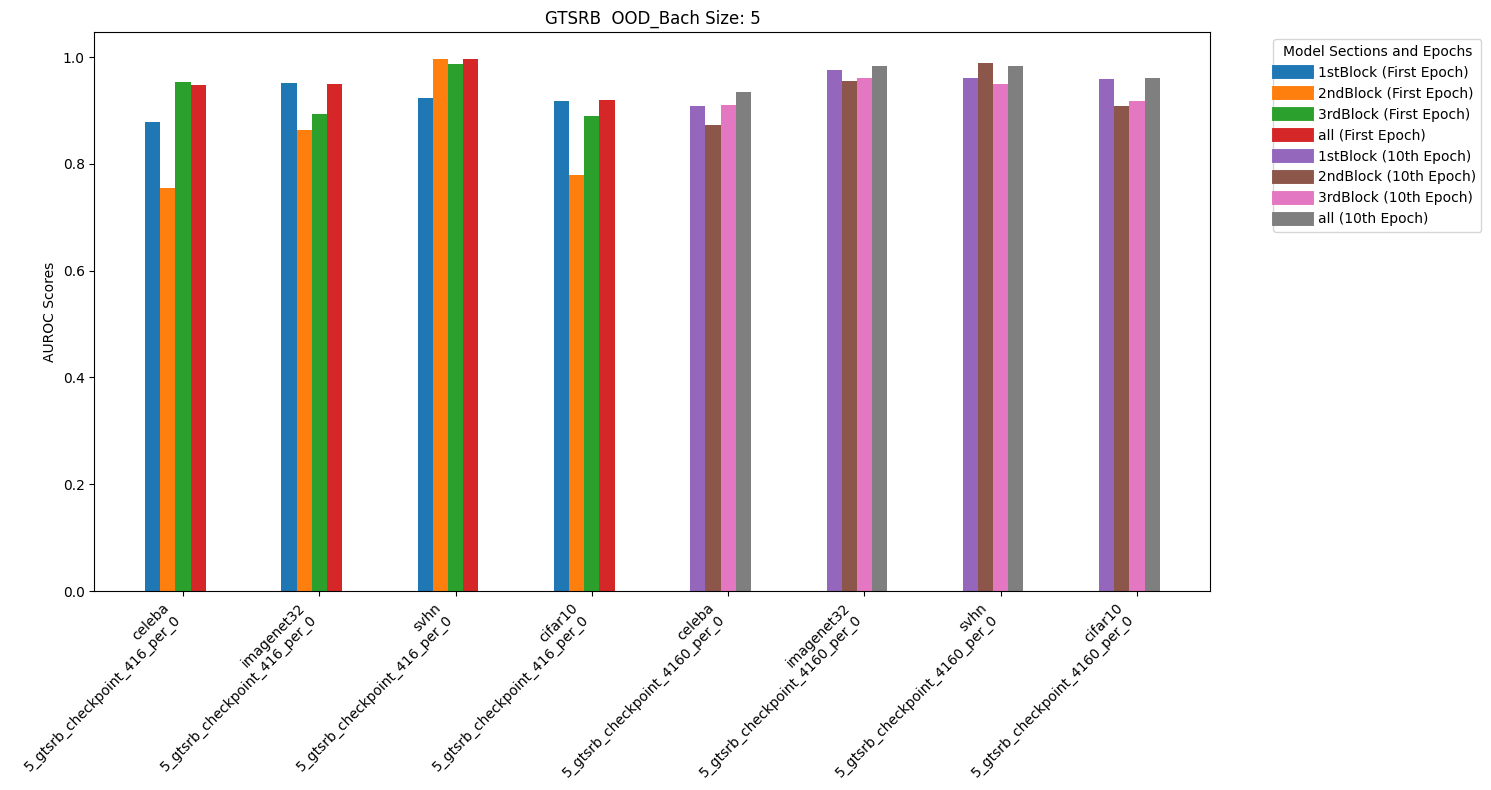

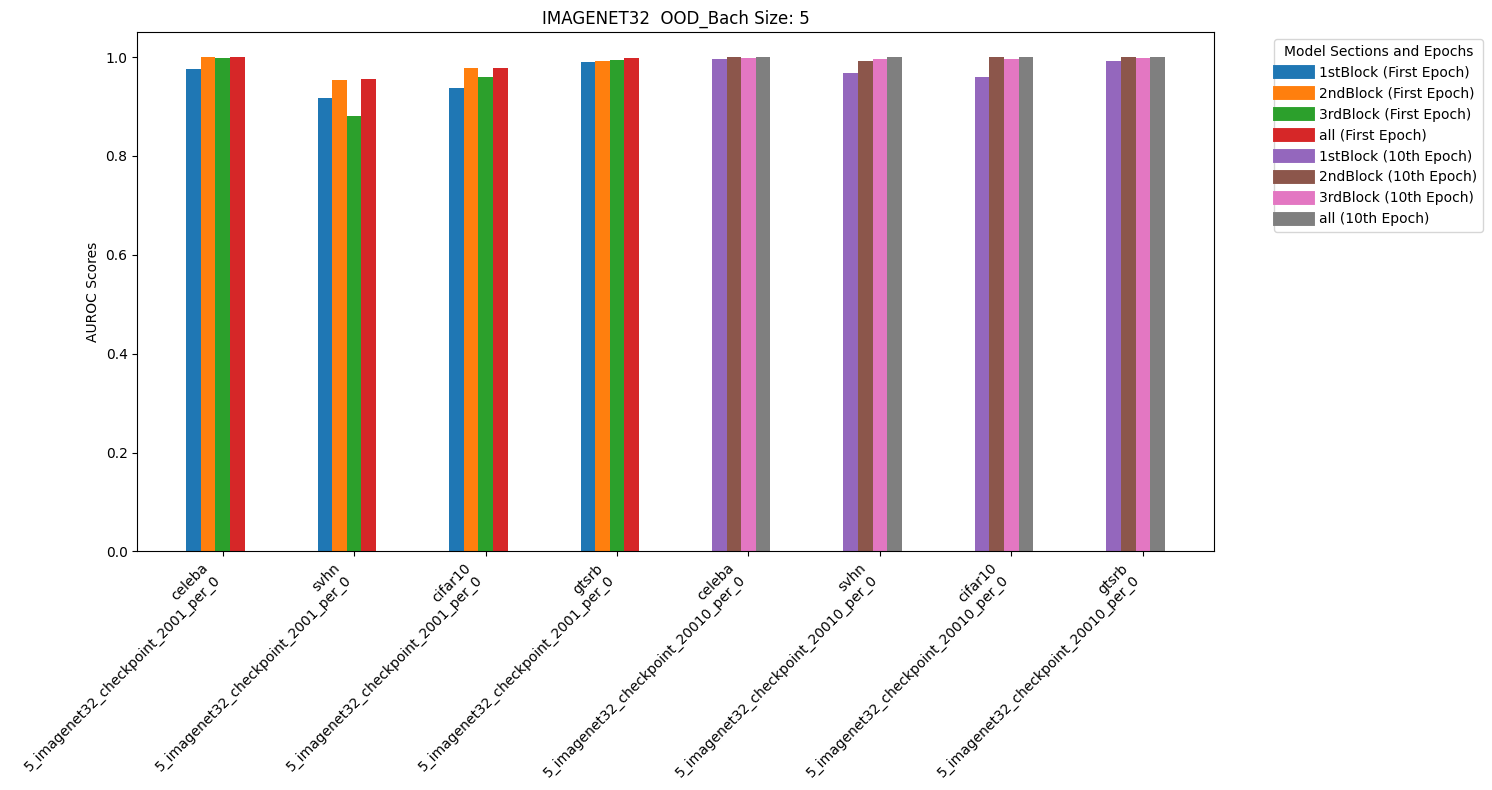

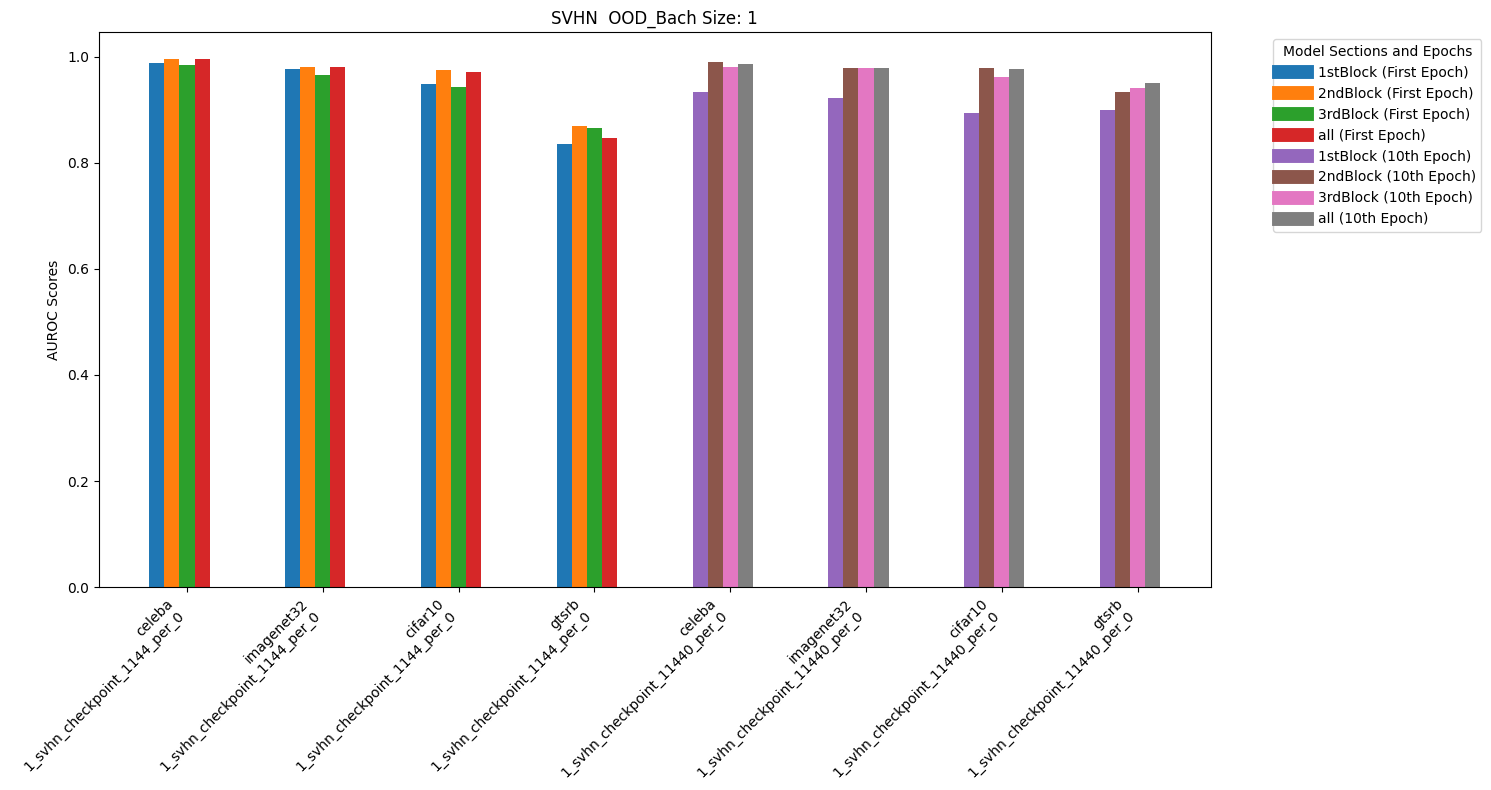

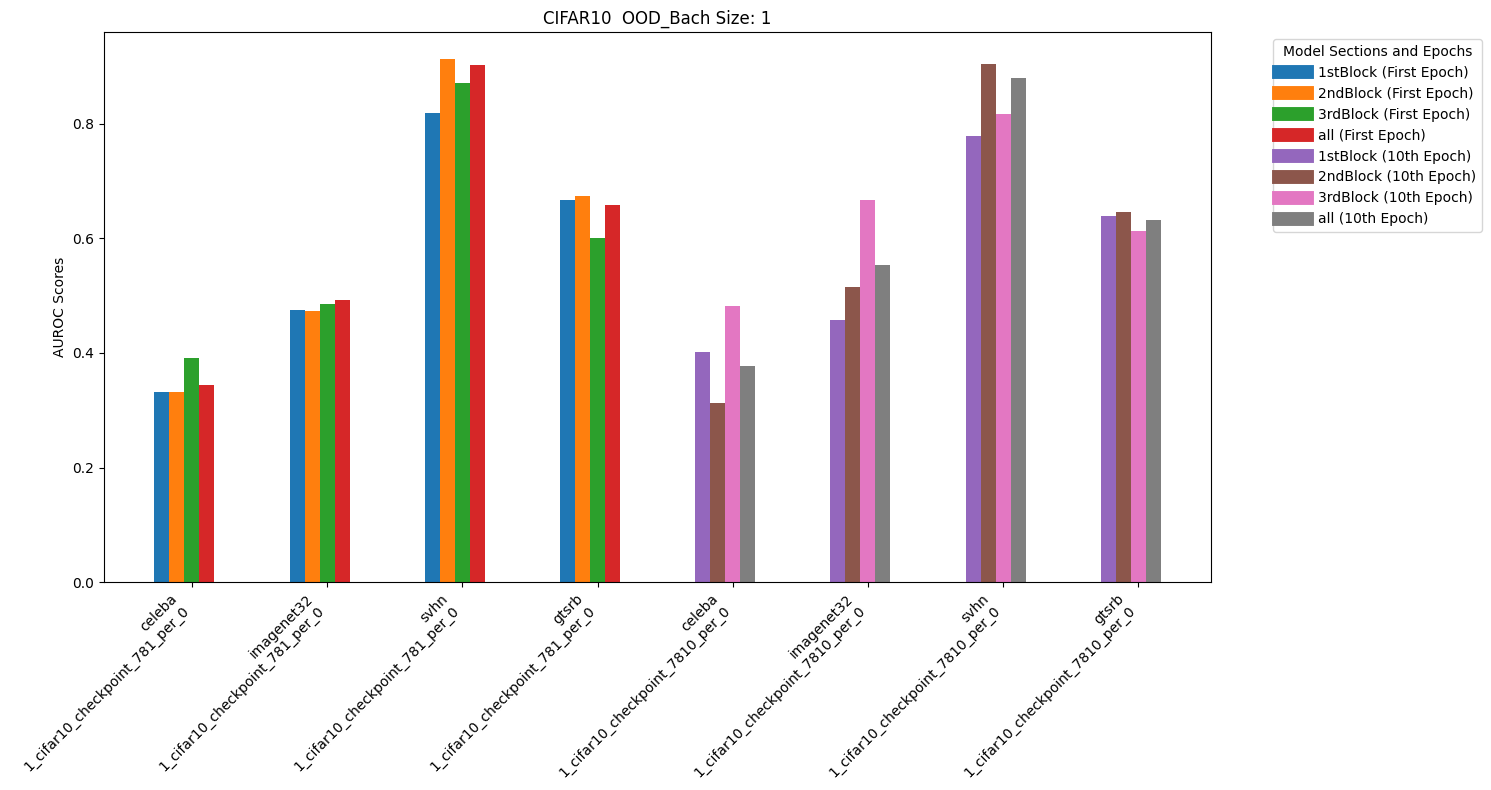

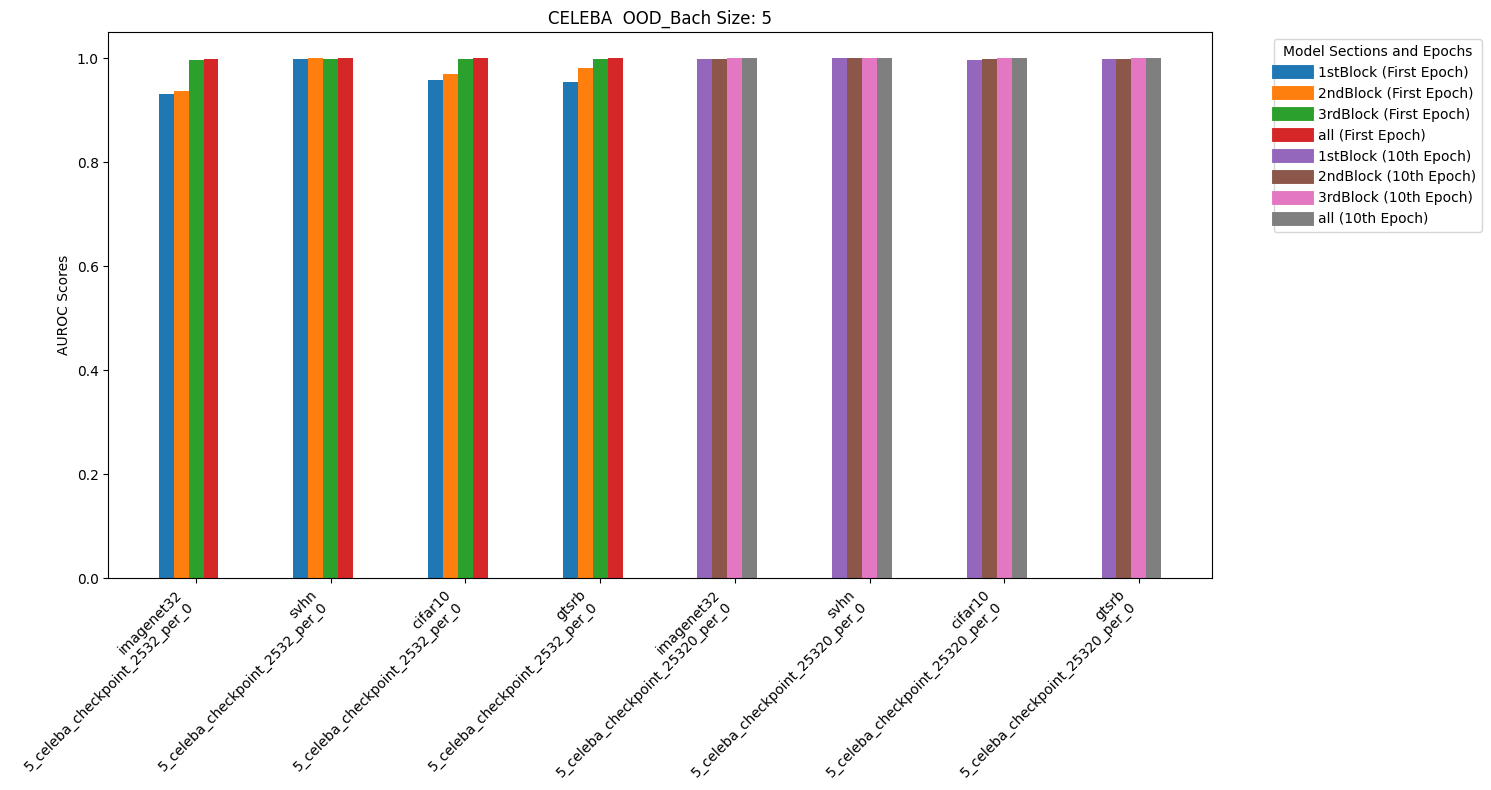

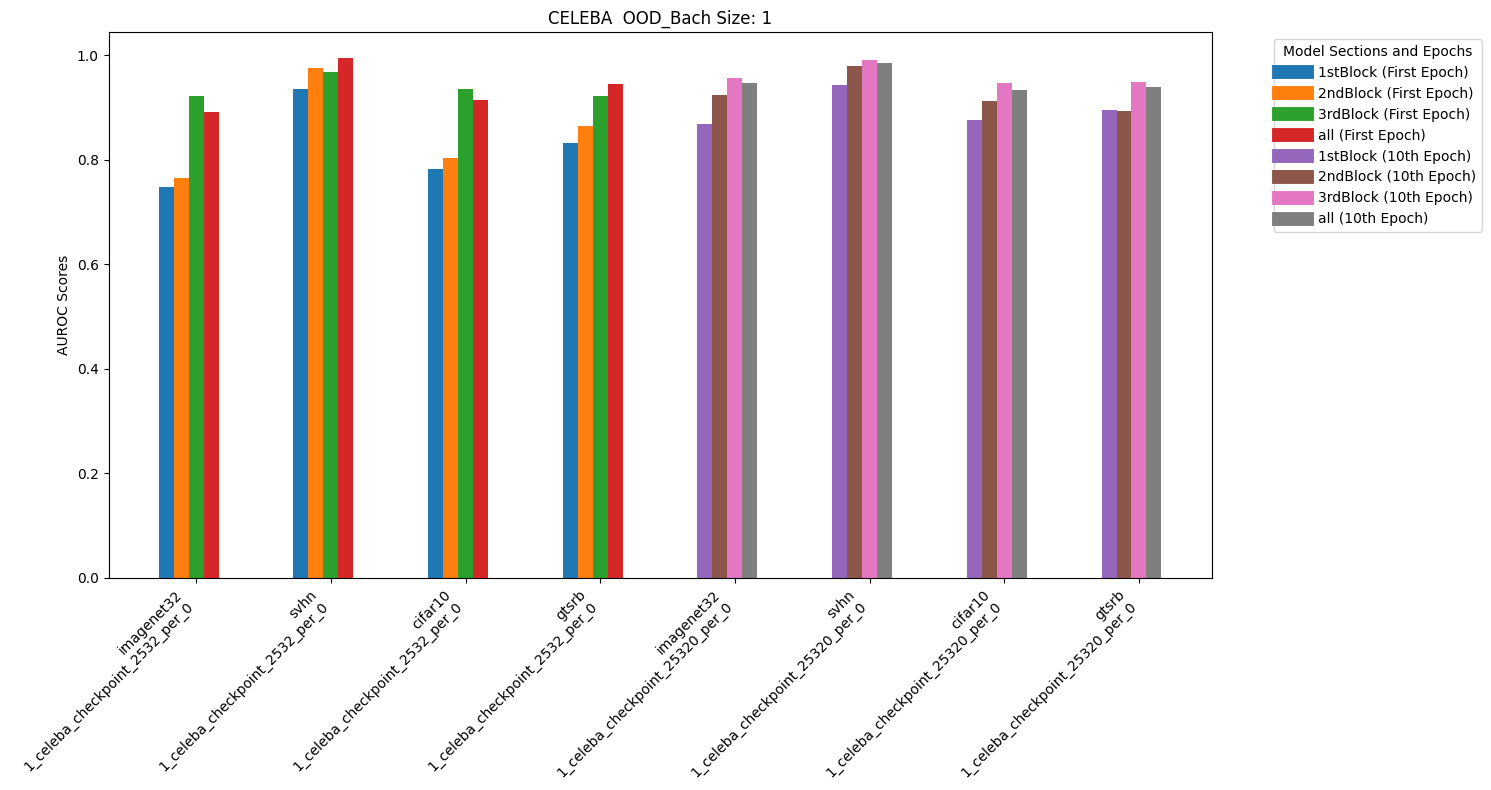

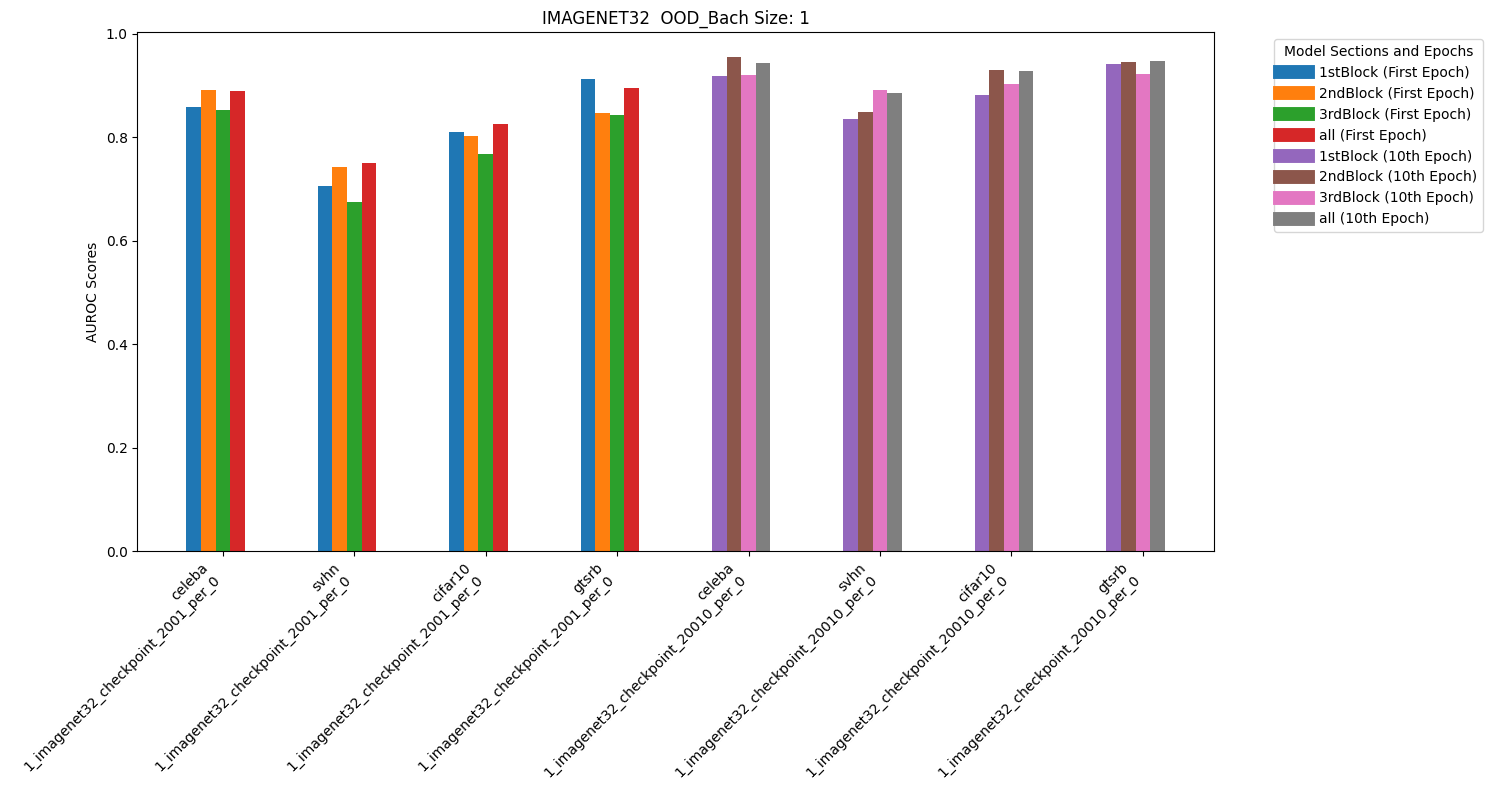

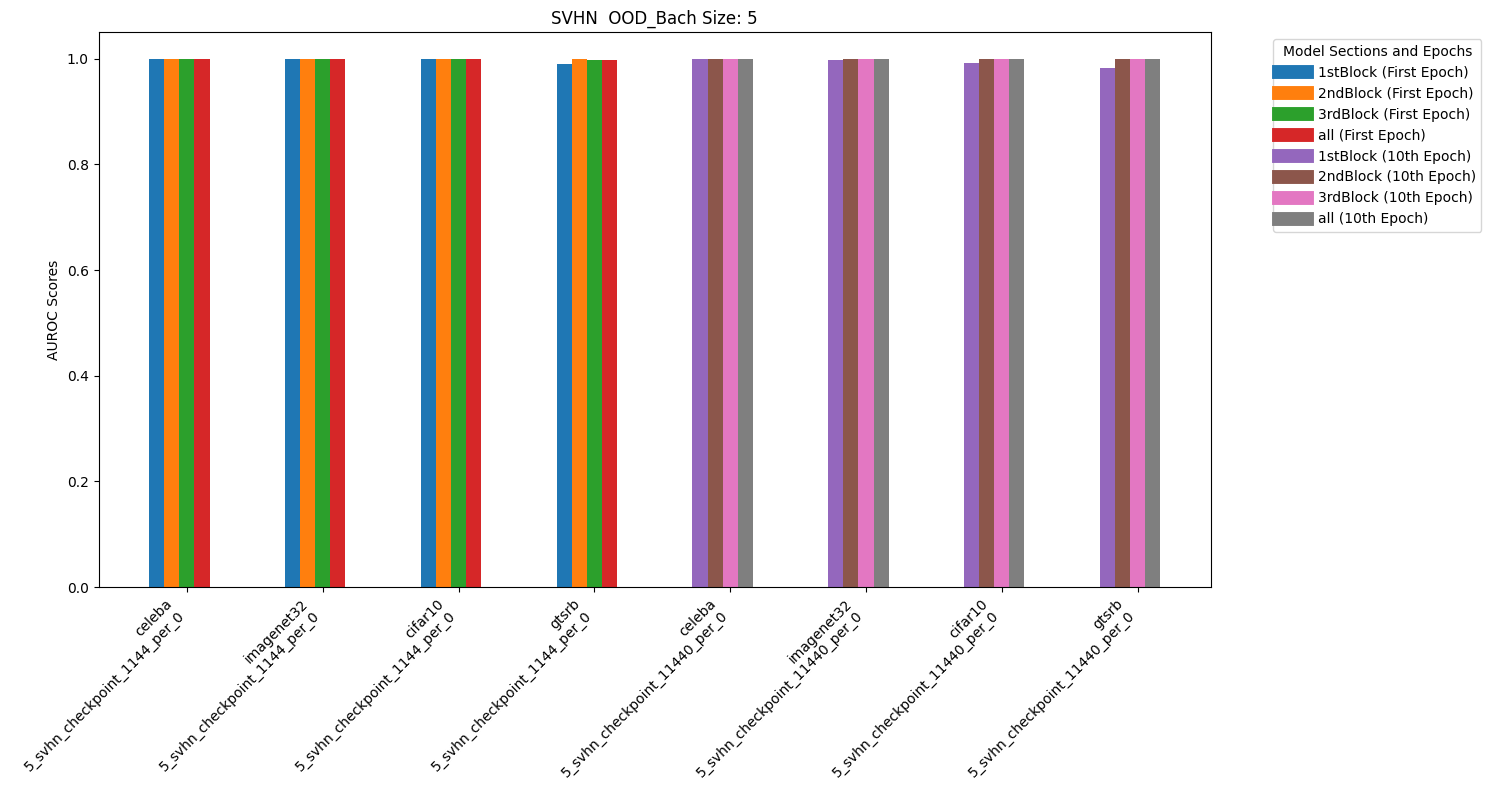

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the CSV file
csv_file = "consolidated_output.csv"  # Replace with your file path
df = pd.read_csv(csv_file, index_col=0)

# Filter columns that end with 'per_0'
filtered_columns = [col for col in df.columns if col.endswith('per_0')]
df_filtered = df[filtered_columns]

# Group columns based on their first part (e.g., '1_gtsrb')
grouped_columns = {}
for col in df_filtered.columns:
    group = col.split('_')[0] + '_' + col.split('_')[1]  # Extract the first two parts of the column name
    if group not in grouped_columns:
        grouped_columns[group] = []
    grouped_columns[group].append(col)

# Define colors for bars
colors_first_three = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for the first three sub-bar charts
colors_last_three = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']  # Colors for the last three sub-bar charts

# Plot each group separately
for group_name, columns in grouped_columns.items():
    # Filter out columns with null or zero values
    valid_columns = []
    for col in columns:
        # Check if any cell in the column is non-null and non-zero
        column_values = df_filtered[col].dropna()  # Drop nulls
        is_valid = any(float(x) > 0 for cell in column_values for x in cell.split(', ') if isinstance(cell, str))
        if is_valid:
            valid_columns.append(col)
    
    if not valid_columns:
        continue  # Skip plotting if no valid columns exist in this group
    
    df_group = df_filtered[valid_columns]  # Select valid columns for this group
    
    # Preprocess the data
    rows = df_group.index.tolist()  # Extract row names
    blocks = ['1stBlock', '2ndBlock', '3rdBlock', 'all']  # File blocks

    data = {}
    for row in rows:
        data[row] = [
            list(map(float, cell.split(', '))) if isinstance(cell, str) and cell else [0, 0, 0, 0]
            for cell in df_group.loc[row, valid_columns]
        ]

    # Create the plot for this group
    fig, ax = plt.subplots(figsize=(15, 8))

    x_positions = []  # Track x-axis positions for bars
    x_labels = []  # Track x-axis labels
    bar_width = 0.2  # Width of individual bars
    space_between_groups = 1.0  # Space between column groups

    x = 0  # Start x position
    for col_idx, col in enumerate(valid_columns):
        for row in rows:
            # Get data for valid columns only
            values = data[row][col_idx]
            if any(values):  # Only plot if there are non-zero values
                # Choose colors based on the sub-bar chart index
                bar_colors = colors_first_three if col_idx < 1 else colors_last_three
                for i, val in enumerate(values):
                    ax.bar(
                        x + i * bar_width, 
                        val, 
                        width=bar_width, 
                        color=bar_colors[i], 
                        label=blocks[i] if x == 0 else ""
                    )
                # Update x-axis labeling
                x_positions.append(x + (bar_width * 2))  # Center of this group
                x_labels.append(f"{row}\n{col}")
                x += bar_width * 4 + space_between_groups  # Shift for next group


    # Create grouped legend
    legend_handles = []
    legend_labels = []

    # Add legend entries for "First Epoch"
    for i, block in enumerate(blocks):
        legend_handles.append(plt.Line2D([0], [0], color=colors_first_three[i], lw=10))
        legend_labels.append(f"{block} (First Epoch)")

    # Add legend entries for "Last Epoch"
    for i, block in enumerate(blocks):
        legend_handles.append(plt.Line2D([0], [0], color=colors_last_three[i], lw=10))
        legend_labels.append(f"{block} (10th Epoch)")


    # Customize x-axis
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.legend(legend_handles, legend_labels, title="Model Sections and Epochs", bbox_to_anchor=(1.05, 1), loc='upper left')

    # # Add legend and title
    ax.set_title(f"{group_name.split('_')[1].upper()}  OOD_Bach Size: {group_name.split('_')[0]}")
    ax.set_ylabel("AUROC Scores")

    # Show the plot
    plt.tight_layout()
    plt.savefig("plots/"+ f"{group_name}_barchart.png")
    plt.show()


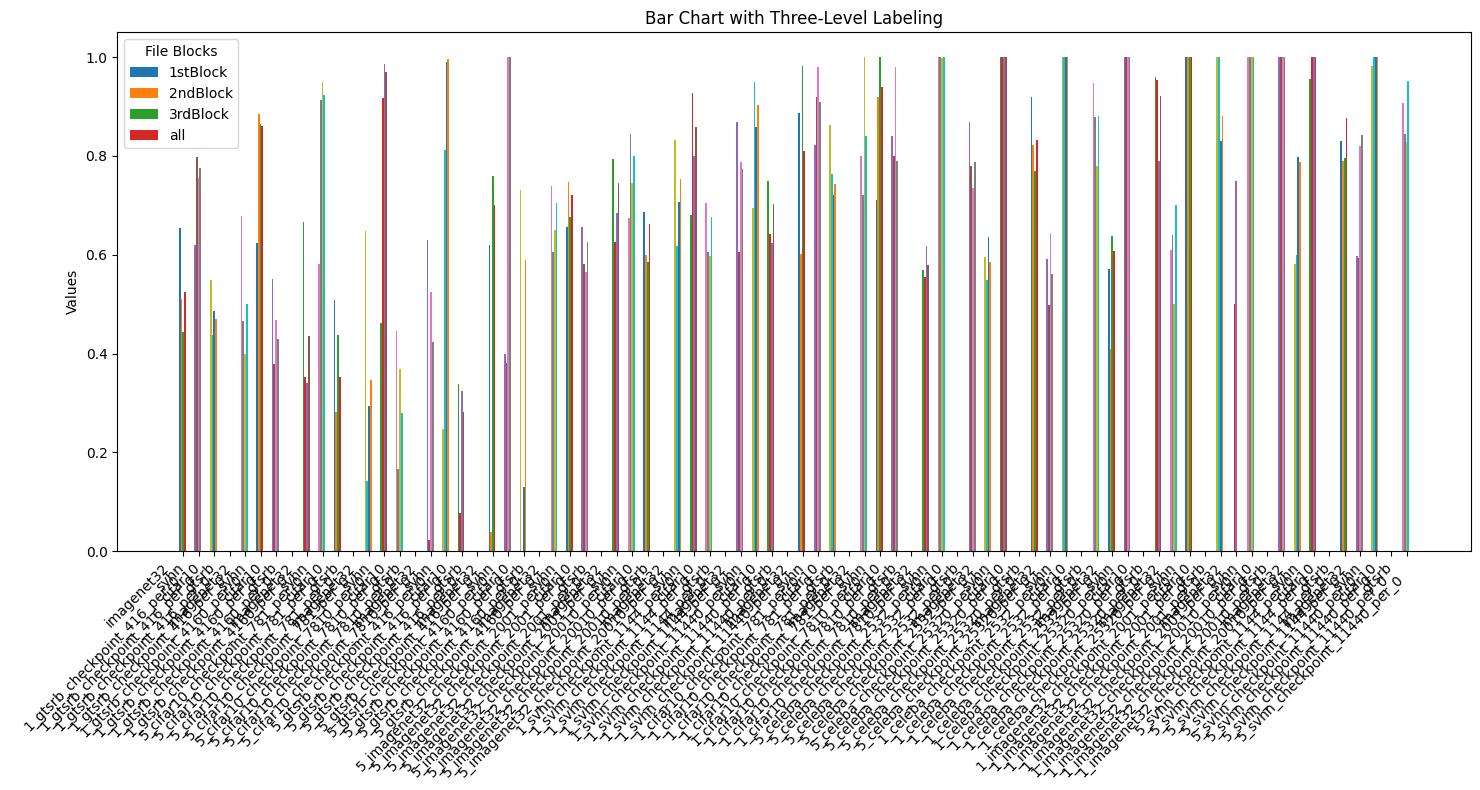

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np




# Load the CSV file
csv_file = "consolidated_output.csv"  # Replace with your file path
df = pd.read_csv(csv_file, index_col=0)

# Filter columns that end with 'per_0'
filtered_columns = [col for col in df.columns if col.endswith('per_0')]
df_filtered = df[filtered_columns]

# Configurations for x-axis levels
columns = df_filtered.columns.tolist()  # Extract filtered column names
rows = df_filtered.index.tolist()
# # Configurations for x-axis levels
# columns = df.columns.tolist()  # Extract column names from the CSV
# rows = df.index.tolist()  # Extract row names (e.g., imagenet32, svhn, cifar10)
blocks = ['1stBlock', '2ndBlock', '3rdBlock', 'all']

# Preprocess the data
# Split each cell's string into an array of float values
data = {}
for row in rows:
    data[row] = [list(map(float, cell.split(', '))) if isinstance(cell, str) else [0, 0, 0, 0] for cell in df.loc[row]]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

x_positions = []  # Track x-axis positions for bars
x_labels = []  # Track x-axis labels
x_ticks = []  # Track x-ticks

bar_width = 0.2  # Width of individual bars
space_between_groups = 1.0  # Space between column groups

x = 0  # Start x position
for col in columns:
    for row in rows:
        # Add bars for each block
        values = data[row][columns.index(col)]
        for i, val in enumerate(values):
            ax.bar(x + i * bar_width, val, width=bar_width, label=blocks[i] if x == 0 else "")
        # Update x-axis labeling
        x_positions.append(x + (bar_width * 2))  # Center of this group
        x_labels.append(f"{row}\n{col}")
        x += bar_width * 4 + space_between_groups  # Shift for next group

# Customize x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Add legend and title
ax.legend(blocks, title="File Blocks")
ax.set_title("Bar Chart with Three-Level Labeling")
ax.set_ylabel("Values")

# Show the plot
plt.tight_layout()
plt.show()


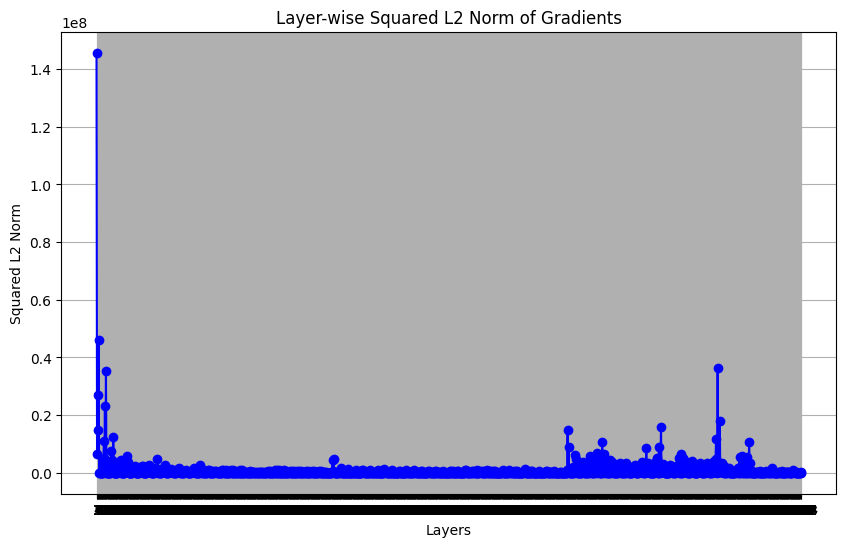

In [9]:
import matplotlib.pyplot as plt

# Assuming `features` is the list or tensor of layer-wise L2 norms returned by gradient_features function
def plot_layer_wise_features(features):
    # Number of layers (same as the number of features)
    num_layers = len(features)

    # Create a range for the layers
    layers = range(1, num_layers + 1)

    # Plotting the features
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(layers, features, marker='o', linestyle='-', color='b')  # Line plot with markers
    plt.title('Layer-wise Squared L2 Norm of Gradients')
    plt.xlabel('Layers')
    plt.ylabel('Squared L2 Norm')
    plt.xticks(layers)  # Set x-axis ticks to be the layer numbers
    plt.grid(True)  # Add a grid for easier visualization
    plt.show()  # Display the plot

# Plot the layer-wise features
plot_layer_wise_features(features_scalar)  


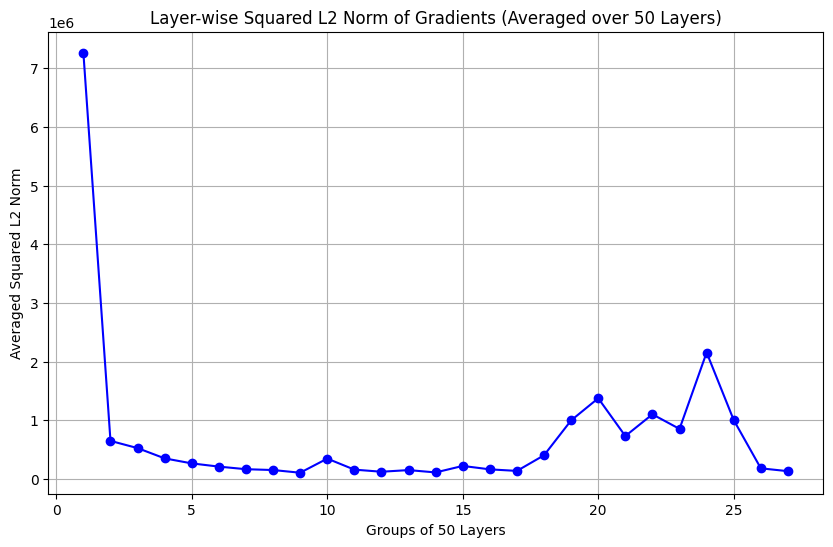

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_layer_wise_features(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Corresponding layer indices
    grouped_layers = range(1, len(grouped_features) + 1)

    # Plotting the features
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_layers, grouped_features, marker='o', linestyle='-', color='b')
    plt.title(f'Layer-wise Squared L2 Norm of Gradients (Averaged over {group_size} Layers)')
    plt.xlabel(f'Groups of {group_size} Layers')
    plt.ylabel('Averaged Squared L2 Norm')
    plt.grid(True)
    plt.show()

 # Average every 50 layers
plot_layer_wise_features(features_scalar, group_size=50) 


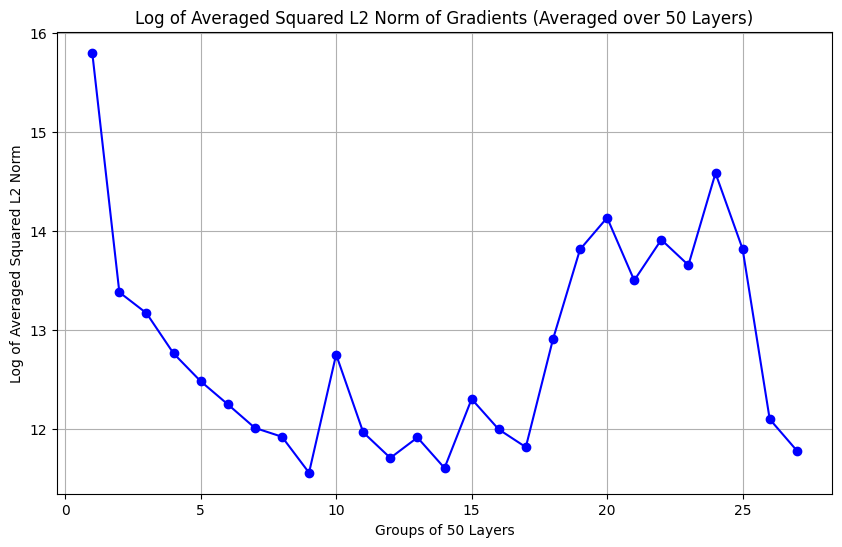

In [11]:
def plot_layer_wise_features_log_avg(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Apply logarithmic scaling
    log_grouped_features = np.log1p(grouped_features)  # Using log1p for numerical stability (log(1+x))

    # Corresponding layer indices
    grouped_layers = range(1, len(log_grouped_features) + 1)

    # Plotting with logarithmic scaling on y-axis
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_layers, log_grouped_features, marker='o', linestyle='-', color='b')
    plt.title(f'Log of Averaged Squared L2 Norm of Gradients (Averaged over {group_size} Layers)')
    plt.xlabel(f'Groups of {group_size} Layers')
    plt.ylabel('Log of Averaged Squared L2 Norm')
    plt.grid(True)
    plt.show()

# Example usage
plot_layer_wise_features_log_avg(features_scalar, group_size=50)


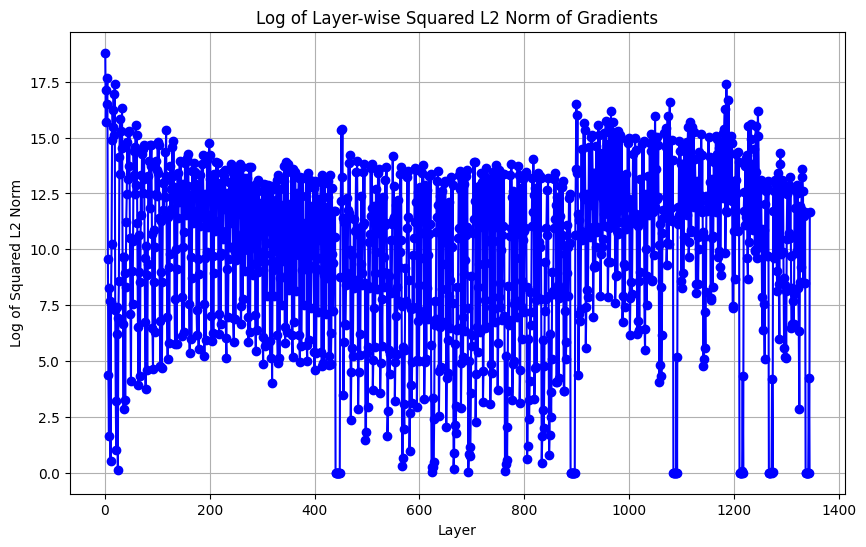

In [12]:
def plot_layer_wise_features_log(features):
    # Apply logarithmic scaling directly to features
    log_features = np.log1p(features)  # Using log1p for numerical stability

    # Layer indices
    layers = range(1, len(log_features) + 1)

    # Plotting the features
    plt.figure(figsize=(10, 6))
    plt.plot(layers, log_features, marker='o', linestyle='-', color='b')
    plt.title(f'Log of Layer-wise Squared L2 Norm of Gradients')
    plt.xlabel('Layer')
    plt.ylabel('Log of Squared L2 Norm')
    plt.grid(True)
    plt.show()

# Example usage
plot_layer_wise_features_log(features_scalar)



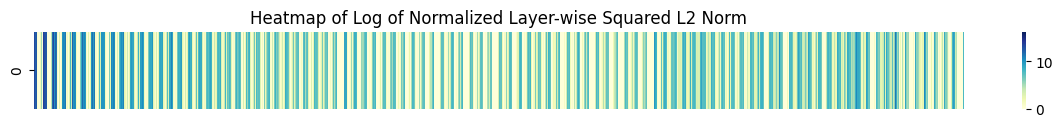

In [13]:
import seaborn as sns

def plot_layer_wise_heatmap_log(features, num_gradients_in_layers):
    # Normalize the features based on num_gradients_in_layers
    normalized_features = [f / n for f, n in zip(features, num_gradients_in_layers)]
    
    # Apply logarithmic scaling
    log_features = np.log1p(normalized_features)  # Using log1p for numerical stability
 
    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(log_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Log of Normalized Layer-wise Squared L2 Norm')
    plt.show()

# Example usage
plot_layer_wise_heatmap_log(features_scalar, num_gradients_in_layers)

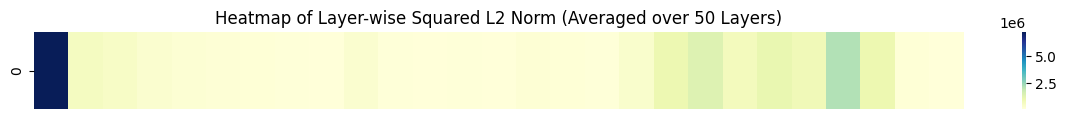

In [14]:
def plot_layer_wise_heatmap(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(grouped_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Layer-wise Squared L2 Norm (Averaged over {group_size} Layers)')
    plt.show()

# Example usage
plot_layer_wise_heatmap(features_scalar, group_size=50)


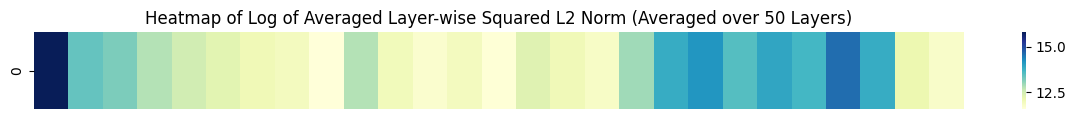

In [15]:
def plot_layer_wise_heatmap_log(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Apply logarithmic scaling
    log_grouped_features = np.log1p(grouped_features)  # Using log1p for numerical stability

    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(log_grouped_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Log of Averaged Layer-wise Squared L2 Norm (Averaged over {group_size} Layers)')
    plt.show()

# Example usage
plot_layer_wise_heatmap_log(features_scalar, group_size=50)


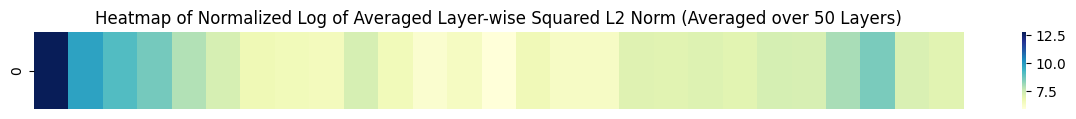

In [16]:
def plot_layer_wise_heatmap_log(features, num_gradients_in_layers, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    normalized_features = [f / n for f, n in zip(features, num_gradients_in_layers)]
    grouped_features = [
        np.mean(normalized_features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Apply logarithmic scaling
    log_grouped_features = np.log1p(grouped_features)  # Using log1p for numerical stability

    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(log_grouped_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Normalized Log of Averaged Layer-wise Squared L2 Norm (Averaged over {group_size} Layers)')
    plt.show()

# Example usage
plot_layer_wise_heatmap_log(features_scalar, num_gradients_in_layers, group_size=50)

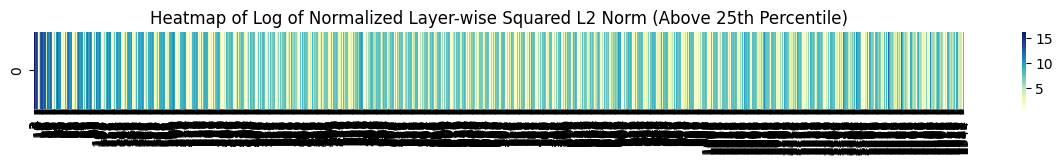

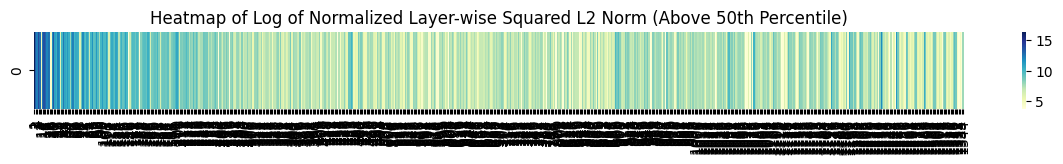

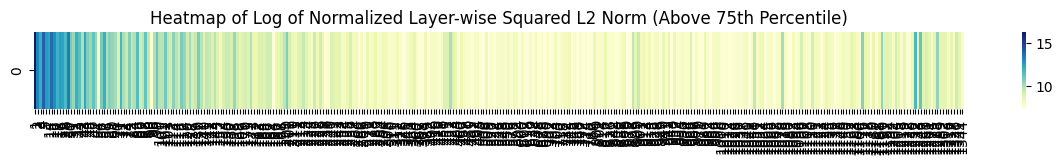

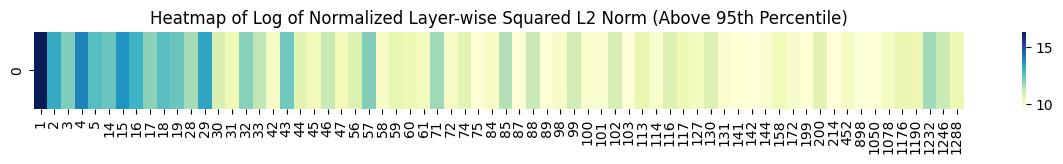

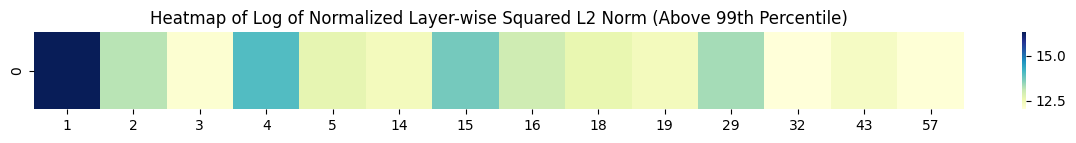

In [17]:
def plot_percentile_heatmap(features, num_gradients_in_layers, percentiles = [25, 50, 75, 95, 99]):
    # Normalize the features based on num_gradients_in_layers
    normalized_features = [f / n for f, n in zip(features, num_gradients_in_layers)]
    
    # Apply logarithmic scaling
    log_features = np.log1p(normalized_features)  # Using log1p for numerical stability

    percentiles = percentiles
    thresholds = np.percentile(log_features, percentiles)
    filtered_features = {p: [(i+1, f) for i, f in enumerate(log_features) if f > t] for p, t in zip(percentiles, thresholds)}
    for p, features in filtered_features.items():
        if features:
            layer_positions, filtered_features = zip(*features)
            heatmap_data = np.array(filtered_features).reshape(1, -1)
            
            plt.figure(figsize=(15, 1))
            sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=layer_positions)
            plt.title(f'Heatmap of Log of Normalized Layer-wise Squared L2 Norm (Above {p}th Percentile)')
            plt.show()

# Example usage
plot_percentile_heatmap(features_scalar, num_gradients_in_layers, percentiles = [25, 50, 75, 95, 99])

In [ ]:
def plot_percentile_heatmap(fit_dataset_name, test_filename, features, num_gradients_in_layers, percentiles = [25, 50, 75, 95, 99], checkpoint="", output_dir=None):
    """Plot a heatmap of the log of normalized layer-wise squared L2 norms above the given percentiles."""
    # Normalize the features based on num_gradients_in_layers
    normalized_features = [f / n for f, n in zip(features, num_gradients_in_layers)]
    
    # Apply logarithmic scaling
    log_features = np.log1p(normalized_features)  # Using log1p for numerical stability

    thresholds = np.percentile(log_features, percentiles)
    filtered_features = {p: [(i+1, f) for i, f in enumerate(log_features) if f > t] for p, t in zip(percentiles, thresholds)}
    # TODO: use subplot to plot all percentiles in one figure and save it
    fig, axs = plt.subplots(len(percentiles), 1, figsize=(15, len(percentiles) * 2), constrained_layout=True)
    
    for ax, (p, feature) in zip(axs, filtered_features.items()):
        if feature:
            layer_positions, filtered_features = zip(*feature)
            heatmap_data = np.array(filtered_features).reshape(1, -1)
            
            sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=layer_positions, ax=ax)
            ax.set_title(f'Log of Normalized Layer-wise Squared L2 Norm (Above {p}th Percentile)')
    
    if test_filename:
        fig.suptitle(f'Log of Normalized Layer-wise Squared L2 Norm on {fit_dataset_name} vs. {test_filename} using {checkpoint}', fontsize=16)
        plot_filename = f'percentile_heatmap_{fit_dataset_name}_vs_{test_filename}_checkpoint_{checkpoint}.png'
    else:
        fig.suptitle(f'Log of Normalized Layer-wise Squared L2 Norm on {fit_dataset_name} using {checkpoint}', fontsize=16)
        plot_filename = f'percentile_heatmap_{fit_dataset_name}_checkpoint_{checkpoint}.png'
    # Save the figure

    # plot_filename = f'percentile_heatmap_{fit_dataset_name}_vs_{test_filename}_checkpoint_{checkpoint}.png'
    plt.savefig(path.join(output_dir, plot_filename))
    plt.show()



def process_and_plot(file_path):
    """Process files, read scores, and plot histograms and AUROC"""
    output_plot_dir = path.join(file_path, "plots")

    # Create output directory if it doesn't exist
    makedirs(output_plot_dir, exist_ok=True)

    # Group files by checkpoint
    grouped_files = group_files_by_checkpoint(file_path)
    
    for checkpoint, files in grouped_files.items():
        # Read fit scores
        fit_filename = files['fit']
        fit_info = parse_filename(fit_filename)
        fit_dataset_name = fit_info[2]
        f_path = path.join(file_path, fit_filename)
        fit_scores = read_properties(f_path, prop="ood_scores")
        analyzer_plots(file_path, fit_dataset_name=fit_dataset_name, test_filename=None, checkpoint=checkpoint, output_dir=output_plot_dir)

        # Read test scores for each test dataset in this checkpoint group
        test_scores_dict = {}
        # test_scores_list = []
        for test_filename in files['tests']:
            test_info = parse_filename(test_filename)
            test_dataset_name = test_info[2]
            f_path = path.join(file_path, test_filename)
            test_scores = read_properties(f_path, prop="ood_scores")
            test_scores_dict[test_dataset_name] = test_scores
            # test_scores_list.append(test_scores)
            analyzer_plots(file_path, fit_dataset_name, test_filename, checkpoint, output_plot_dir)


def analyzer_plots(file_path, fit_dataset_name, test_filename, checkpoint, output_dir):
        """Plot histograms and heatmaps for the given file path."""
        _, num_gradients_in_layers, features_scalar = read_properties(file_path, prop="features")
        # Plot percentile heatmap
        plot_percentile_heatmap(fit_dataset_name, test_filename, features_scalar, num_gradients_in_layers, percentiles = [25, 50, 75, 95, 99], checkpoint=checkpoint, output_dir=output_dir)

# Function to read OOD scores from a file
def read_properties(file_path: str, prop: str="ood_scores"):
    """Read OOD scores from a file"""
    # file_path = path.join(data_path, file_name)
    if path.exists(file_path):
        print(f"File '{file_path}' is loading...")
        checkpoint = torch.load(file_path)
        ood_scores = checkpoint['ood_scores']
        features = checkpoint['features']
        num_features = checkpoint['num_features']
        features_scalar = checkpoint['features_scalar']
        # ood_scores = torch.load(file_path)
        if prop == "ood_scores":
            return torch.cat([score.unsqueeze(0) for score in ood_scores], dim=0).cpu().detach().numpy()
        elif prop == "features":
            return ood_scores, features, num_features, features_scalar
        return None
    else:
        print(f"File '{file_path}' not found.")
        return None

# Example usage


# OOD Score

# Tests


# Augmentation Techniques

In [ ]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms

def histogram_equalization(img: Image.Image):
    # Convert PIL image to NumPy array
    img_np = np.array(img)
    if len(img_np.shape) == 3:  # Color image
        img_yuv = cv2.cvtColor(img_np, cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])  # Apply HE to the Y channel
        img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    else:  # Grayscale image
        img_eq = cv2.equalizeHist(img_np)
    return Image.fromarray(img_eq)

# Example usage in transform pipeline
transform = transforms.Compose([
    transforms.Lambda(histogram_equalization),
    transforms.ToTensor()
])

from torchvision.transforms import ColorJitter

transform = transforms.Compose([
    ColorJitter(brightness=0.5, contrast=0.5),  # Adjust brightness and contrast
    transforms.ToTensor()
])

def white_balance(img: Image.Image):
    img_np = np.array(img).astype(np.float32)
    img_mean = np.mean(img_np, axis=(0, 1))  # Mean per channel
    img_balanced = (img_np / img_mean) * 128  # Normalize and scale
    img_balanced = np.clip(img_balanced, 0, 255).astype(np.uint8)
    return Image.fromarray(img_balanced)

# Example usage in transform pipeline
transform = transforms.Compose([
    transforms.Lambda(white_balance),
    transforms.ToTensor()
])

from PIL import ImageFilter

def sharpening(img: Image.Image):
    return img.filter(ImageFilter.SHARPEN)

# Example usage in transform pipeline
transform = transforms.Compose([
    transforms.Lambda(sharpening),
    transforms.ToTensor()
])

from PIL import ImageFilter

# Using PIL
def blurring(img: Image.Image):
    return img.filter(ImageFilter.GaussianBlur(radius=2))  # Radius defines the blur intensity

# Using torchvision.transforms
from torchvision.transforms import GaussianBlur

transform = transforms.Compose([
    GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Apply Gaussian blur
    transforms.ToTensor()
])


# Augmentation

In [2]:
from os import listdir, path, makedirs
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import GTSRB, CIFAR10
from PIL import Image
from utilities.routes import DATAROOT
from tqdm import tqdm
import torch.nn.functional as F

import os
from torchvision import transforms
from torchvision.datasets import GTSRB
from PIL import Image

# Save augmented images of GTSRB test dataset
def save_augmented_train_dataset(dataroot, output_dir, num_augmentations=4):
    """
    Create and save an augmented version of the train dataset in a format compatible
    with DatasetFolder (organized by class).
    """
    
    # Define test-time augmentations
    augmentation_transform = transforms.Compose([
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(degrees=10),
    ])
    root = path.join(dataroot, "GTSRB")
    # Load the original test dataset
    test_dataset = GTSRB(
        root=root,
        split="test",
        transform=None,  # Don't apply transformations yet
        download=True,
    )

    output_dir = path.join(root, output_dir)
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Augment and save images
    for idx, (image, label) in tqdm(enumerate(test_dataset), desc="Augmenting train dataset", total=len(test_dataset)):
        # Create a subdirectory for the class label
        class_dir = os.path.join(output_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)
        
        # Save the original image
        original_filename = os.path.join(class_dir, f"img_{idx}_original.ppm")
        image.save(original_filename)
        
        # Save augmented versions
        for aug_idx in range(num_augmentations):
            augmented_image = augmentation_transform(image)
            augmented_filename = os.path.join(class_dir, f"img_{idx}_aug_{aug_idx}.ppm")
            augmented_image.save(augmented_filename)
    
    print(f"Augmented dataset saved to {output_dir}")


# # Save augmented images of CIFAR10 test dataset
# def save_augmented_train_dataset(dataroot, output_dir, num_augmentations=4):
#     """
#     Create and save an augmented version of the test dataset in a format compatible
#     with DatasetFolder (organized by class).
#     """
    
#     # Define test-time augmentations
#     augmentation_transform = transforms.Compose([
#             transforms.RandomAffine(0, translate=(0.1, 0.1)),
#             transforms.RandomHorizontalFlip(),
#             transforms.ColorJitter(brightness=0.2, contrast=0.2),
#             transforms.RandomRotation(degrees=10),
#     ])
#     root = path.join(dataroot, "CIFAR10")
#     # Load the original test dataset
#     test_dataset = CIFAR10(
#         root=root,
#         train=False,
#         transform=None,
#         # target_transform=one_hot_encode,
#         download=True,
#     )

#     output_dir = path.join(root, output_dir)
#     # Ensure the output directory exists
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Augment and save images
#     for idx, (image, label) in tqdm(enumerate(test_dataset), desc="Augmenting train dataset", total=len(test_dataset)):
#         # Create a subdirectory for the class label
#         class_dir = os.path.join(output_dir, str(label))
#         os.makedirs(class_dir, exist_ok=True)
        
#         # Save the original image
#         original_filename = os.path.join(class_dir, f"img_{idx}_original.ppm")
#         image.save(original_filename)
        
#         # Save augmented versions
#         for aug_idx in range(num_augmentations):
#             augmented_image = augmentation_transform(image)
#             augmented_filename = os.path.join(class_dir, f"img_{idx}_aug_{aug_idx}.ppm")
#             augmented_image.save(augmented_filename)
    
#     print(f"Augmented dataset saved to {output_dir}")


save_augmented_train_dataset(dataroot=DATAROOT, output_dir="augmented_train_dataset")



Augmenting train dataset: 100%|██████████| 12630/12630 [15:31<00:00, 13.56it/s]

Augmented dataset saved to /net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/data/GTSRB/augmented_train_dataset


In [ ]:
from os import listdir, path, makedirs
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import GTSRB, CIFAR10
from PIL import Image
from utilities.routes import DATAROOT
from tqdm import tqdm
import torch.nn.functional as F

import os
from torchvision import transforms
from torchvision.datasets import GTSRB
from PIL import Image

# Save augmented images of GTSRB test dataset
def save_augmented_test_dataset(dataroot, output_dir, num_augmentations=4):
    """
    Create and save an augmented version of the test dataset in a format compatible
    with DatasetFolder (organized by class).
    """
    
    # Define test-time augmentations
    augmentation_transform = transforms.Compose([
        transforms.RandomAffine(0, translate=(0.02, 0.02)),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1),
        # transforms.RandomHorizontalFlip(p=0.5),
    ])
    root = path.join(dataroot, "GTSRB")
    # Load the original test dataset
    test_dataset = GTSRB(
        root=root,
        split="test",
        transform=None,  # Don't apply transformations yet
        download=True,
    )

    output_dir = path.join(root, output_dir)
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Augment and save images
    for idx, (image, label) in tqdm(enumerate(test_dataset), desc="Augmenting test dataset", total=len(test_dataset)):
        # Create a subdirectory for the class label
        class_dir = os.path.join(output_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)
        
        # Save the original image
        original_filename = os.path.join(class_dir, f"img_{idx}_original.ppm")
        image.save(original_filename)
        
        # Save augmented versions
        for aug_idx in range(num_augmentations):
            augmented_image = augmentation_transform(image)
            augmented_filename = os.path.join(class_dir, f"img_{idx}_aug_{aug_idx}.ppm")
            augmented_image.save(augmented_filename)
    
    print(f"Augmented dataset saved to {output_dir}")


# # Save augmented images of CIFAR10 test dataset
# def save_augmented_test_dataset(dataroot, output_dir, num_augmentations=4):
#     """
#     Create and save an augmented version of the test dataset in a format compatible
#     with DatasetFolder (organized by class).
#     """
    
#     # Define test-time augmentations
#     augmentation_transform = transforms.Compose([
#         transforms.RandomAffine(0, translate=(0.02, 0.02)),
#         # transforms.ColorJitter(brightness=0.1, contrast=0.1),
#         transforms.RandomHorizontalFlip(p=0.5),
#     ])
#     root = path.join(dataroot, "CIFAR10")
#     # Load the original test dataset
#     test_dataset = CIFAR10(
#         root=root,
#         train=False,
#         transform=None,
#         # target_transform=one_hot_encode,
#         download=True,
#     )

#     output_dir = path.join(root, output_dir)
#     # Ensure the output directory exists
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Augment and save images
#     for idx, (image, label) in tqdm(enumerate(test_dataset), desc="Augmenting test dataset", total=len(test_dataset)):
#         # Create a subdirectory for the class label
#         class_dir = os.path.join(output_dir, str(label))
#         os.makedirs(class_dir, exist_ok=True)
        
#         # Save the original image
#         original_filename = os.path.join(class_dir, f"img_{idx}_original.ppm")
#         image.save(original_filename)
        
#         # Save augmented versions
#         for aug_idx in range(num_augmentations):
#             augmented_image = augmentation_transform(image)
#             augmented_filename = os.path.join(class_dir, f"img_{idx}_aug_{aug_idx}.ppm")
#             augmented_image.save(augmented_filename)
    
#     print(f"Augmented dataset saved to {output_dir}")


save_augmented_test_dataset(dataroot=DATAROOT, output_dir="augmented_test_dataset")



Files already downloaded and verified


Augmenting test dataset: 100%|██████████| 10000/10000 [07:49<00:00, 21.31it/s]

Augmented dataset saved to /net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/data/CIFAR10/augmented_test_dataset


In [ ]:
# Load the augmented test dataset
from PIL import Image
from os import path
from utilities.routes import DATAROOT
def ppm_loader(filepath):
    """Loads a .ppm image file."""
    return Image.open(filepath).convert("RGB")

from torchvision.datasets import DatasetFolder
from torchvision import transforms
from torch.utils.data import DataLoader

def load_augmented_test_dataset(augmented_dir, image_shape=(32, 32)):
    """Load the augmented test dataset."""
    
    # Define preprocessing transformations
    preprocessing = transforms.Compose([
        transforms.Resize(image_shape),  # Resize images to the desired shape
        transforms.ToTensor(),          # Convert to PyTorch Tensor
        # Add any additional preprocessing here, e.g., normalization
    ])
    
    # Create a DatasetFolder for loading images and labels
    dataset = DatasetFolder(
        root=augmented_dir,
        loader=ppm_loader,             # Custom loader for .ppm images
        extensions=("ppm",),           # Specify file extensions to include
        transform=preprocessing,       # Apply preprocessing transformations
    )
    return dataset

ds=load_augmented_test_dataset(path.join(DATAROOT, "CIFAR10", "augmented_test_dataset"))

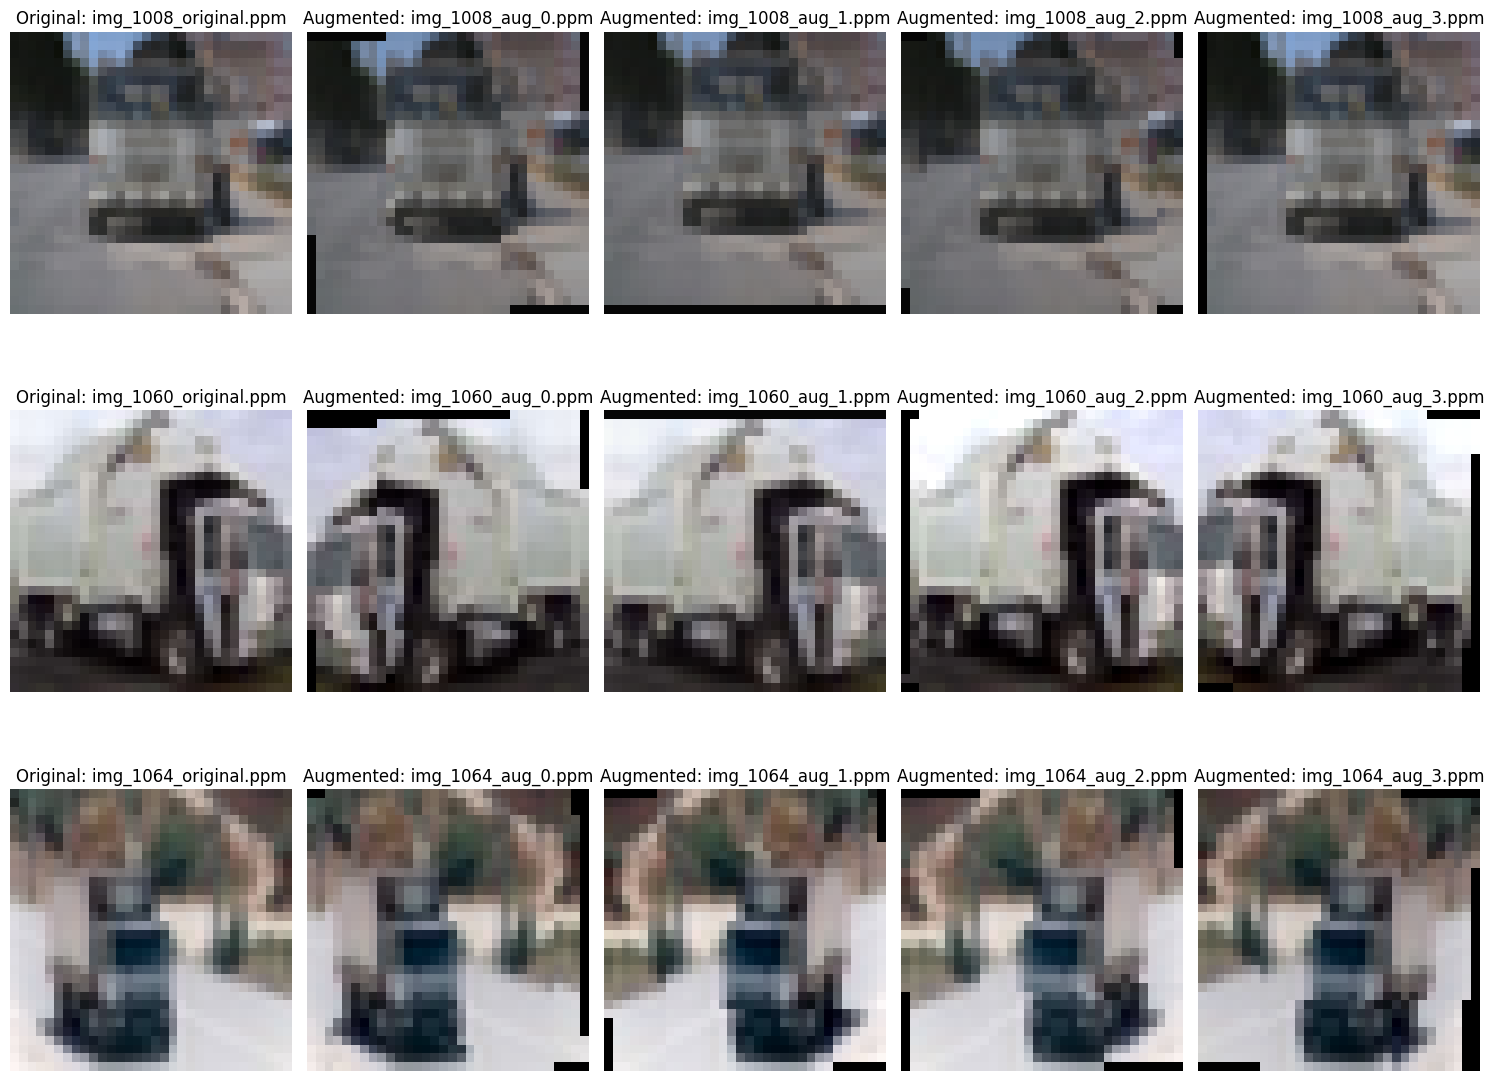

In [ ]:
# Plotting the augmented images from CIFAR10 and GTSRB
import os
import matplotlib.pyplot as plt
from PIL import Image

def plot_original_and_augmented(data_dir, class_label, num_samples=3):
    """
    Plots the original images and their augmentations for a given class.
    
    Args:
        data_dir (str): Path to the root directory of the saved dataset.
        class_label (str): Class label for which images are to be plotted.
        num_samples (int): Number of original images (with augmentations) to plot.
    """
    # Path to the class directory
    class_dir = os.path.join(data_dir, str(class_label))
    if not os.path.exists(class_dir):
        print(f"Class directory {class_dir} does not exist.")
        return
    
    # Collect all images for the given class
    all_images = sorted(os.listdir(class_dir))
    
    # Separate original and augmented images
    original_images = [img for img in all_images if "original" in img]
    
    # Limit to the desired number of samples
    original_images = original_images[:num_samples]
    
    # Plot the images
    fig, axes = plt.subplots(num_samples, 5, figsize=(15, 4 * num_samples))
    if num_samples == 1:  # Handle case with a single original image
        axes = [axes]
    
    for i, orig in enumerate(original_images):
        # Load original image
        orig_path = os.path.join(class_dir, orig)
        orig_img = Image.open(orig_path)
        
        # Plot original image in the first column
        axes[i][0].imshow(orig_img)
        axes[i][0].set_title(f"Original: {orig}")
        axes[i][0].axis("off")
        
        # Load and plot augmentations for the original image
        aug_images = [
            img for img in all_images
            if f"img_{orig.split('_')[1]}" in img and "aug" in img
        ]
        for j, aug in enumerate(sorted(aug_images)[:4]):  # Limit to 4 augmentations
            aug_path = os.path.join(class_dir, aug)
            aug_img = Image.open(aug_path)
            axes[i][j + 1].imshow(aug_img)
            axes[i][j + 1].set_title(f"Augmented: {aug}")
            axes[i][j + 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Path to the saved dataset directory
data_dir = path.join(DATAROOT, "CIFAR10", "augmented_test_dataset")

# Plot original and augmented images for class label '0'
plot_original_and_augmented(data_dir, class_label="9", num_samples=3)

In [21]:
# Check if the transformations are correct
from data.datasets import CIFAR10Wrapper, SVHNWrapper, MNISTWrapper, FashionMNISTWrapper, OmniglotWrapper, FlippedOmniglotWrapper, GTSRBWrapper, ImageNet32Wrapper, CelebAWrapper

# Retrieve train transformations
train_transform = GTSRBWrapper.create_transform(augment=True)
print("Train Transforms:")
print(train_transform)

# Retrieve test transformations
test_transform = GTSRBWrapper.create_transform(augment=False)
print("\nTest Transforms:")
print(test_transform)


Train Transforms:
Compose(
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    <function preprocess at 0x7fd69b7e65f0>
)

Test Transforms:
Compose(
    ToTensor()
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    <function preprocess at 0x7fd69b7e65f0>
)


In [1]:

from torchvision import datasets, transforms
from pathlib import Path
from data.datasets import preprocess, one_hot_encode
def get_CIFAR10(augment, dataroot, download):
    image_shape = (32, 32, 3)
    num_classes = 10

    if augment:
        transformations = [
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.RandomHorizontalFlip(),
        ]
    else:
        transformations = []

    transformations.extend([transforms.ToTensor(), preprocess])
    train_transform = transforms.Compose(transformations)

    test_transform = transforms.Compose([transforms.ToTensor(), preprocess])

    print(f"{train_transform= }\n {test_transform= }")
    path = Path(dataroot) / "data" / "CIFAR10"
    train_dataset = datasets.CIFAR10(
        path,
        train=True,
        transform=train_transform,
        target_transform=one_hot_encode,
        download=download,
    )

    test_dataset = datasets.CIFAR10(
        path,
        train=False,
        transform=test_transform,
        target_transform=one_hot_encode,
        download=download,
    )

    return image_shape, num_classes, train_dataset, test_dataset

cifar = get_CIFAR10(augment=True, dataroot='data', download=False)

train_transform= Compose(
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    <function preprocess at 0x7f1c213296c0>
)
 test_transform= Compose(
    ToTensor()
    <function preprocess at 0x7f1c213296c0>
)


RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [ ]:
import torch.nn.functional as F

def squeeze2d(inputs, factor):
    """ Squeeze input 2D tensor into 4D """
    if factor == 1:
        return inputs

    B, C, H, W = inputs.size()

    # Pad H and W if not divisible by factor (for cases like 28x28 with factor 2)
    if H % factor != 0 or W % factor != 0:
        pad_h = factor - (H % factor) if H % factor != 0 else 0
        pad_w = factor - (W % factor) if W % factor != 0 else 0
        inputs = F.pad(inputs, (0, pad_w, 0, pad_h))

        # Update H and W after padding
        _, _, H, W = inputs.size()

    assert H % factor == 0 and W % factor == 0, f"H={H}, W={W} not divisible by factor={factor}"

    # Reshape and permute
    x = inputs.view(B, C, H // factor, factor, W // factor, factor)
    x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
    x = x.view(B, C * factor * factor, H // factor, W // factor)

    return x

def unsqueeze2d(inputs, factor):
    """ Unsqueeze 4D tensor into 2D """
    if factor == 1:
        return inputs

    factor2 = factor ** 2

    B, C, H, W = inputs.size()

    assert C % factor2 == 0, f"Channels={C} not divisible by factor squared={factor2}"

    # Reshape and permute
    x = inputs.view(B, C // factor2, factor, factor, H, W)
    x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
    x = x.view(B, C // factor2, H * factor, W * factor)

    # Remove any padding if added during squeeze
    orig_H, orig_W = H * factor, W * factor
    if orig_H != inputs.size(2) or orig_W != inputs.size(3):
        x = x[:, :, :orig_H, :orig_W]

    return x


In [ ]:
import torch
# Example inputs: CIFAR-10 image (3, 32, 32) and MNIST image (1, 28, 28)
cifar_input = torch.randn(8, 3, 32, 32)  # Batch of 8 CIFAR images
mnist_input = torch.randn(8, 1, 28, 28)  # Batch of 8 MNIST images

# Apply squeeze and unsqueeze to CIFAR input
squeezed_cifar = squeeze2d(cifar_input, factor=2)
unsqueezed_cifar = unsqueeze2d(squeezed_cifar, factor=2)

# Apply squeeze and unsqueeze to MNIST input
squeezed_mnist = squeeze2d(mnist_input, factor=2)
unsqueezed_mnist = unsqueeze2d(squeezed_mnist, factor=2)

print(f"CIFAR original: {cifar_input.size()}, Squeezed: {squeezed_cifar.size()}, Unsqueezed: {unsqueezed_cifar.size()}")
print(f"MNIST original: {mnist_input.size()}, Squeezed: {squeezed_mnist.size()}, Unsqueezed: {unsqueezed_mnist.size()}")


In [ ]:
import torch
import math

def gaussian_p(mean, logs, x):
    """
    Compute the Gaussian log-probability.
    lnL = -1/2 * { ln|Var| + ((X - Mu)^T)(Var^-1)(X - Mu) + kln(2*PI) }
    """
    c = math.log(2 * math.pi)

    # Broadcasting to ensure the shapes match
    logs = logs.expand_as(x)
    mean = mean.expand_as(x)

    return -0.5 * (logs * 2.0 + ((x - mean) ** 2) / torch.exp(logs * 2.0) + c)

def gaussian_likelihood(mean, logs, x):
    """ Compute Gaussian likelihood and sum over the spatial and channel dimensions. """
    p = gaussian_p(mean, logs, x)
    
    # Sum over all but the batch dimension (dim=0)
    return torch.sum(p, dim=[1, 2, 3])

def gaussian_sample(mean, logs, temperature=1):
    """ Sample from Gaussian with temperature scaling. """
    # Ensure the shapes are broadcasted correctly
    logs = logs.expand_as(mean)

    # Sample from Gaussian distribution with temperature
    z = torch.normal(mean, torch.exp(logs) * temperature)

    return z


In [ ]:
# Example for CIFAR-10 shape (batch_size, 3, 32, 32)
mean_cifar = torch.randn(8, 3, 32, 32)
logs_cifar = torch.randn(8, 3, 32, 32)
x_cifar = torch.randn(8, 3, 32, 32)

likelihood_cifar = gaussian_likelihood(mean_cifar, logs_cifar, x_cifar)
sample_cifar = gaussian_sample(mean_cifar, logs_cifar)

# Example for MNIST shape (batch_size, 1, 28, 28)
mean_mnist = torch.randn(8, 1, 28, 28)
logs_mnist = torch.randn(8, 1, 28, 28)
x_mnist = torch.randn(8, 1, 28, 28)

likelihood_mnist = gaussian_likelihood(mean_mnist, logs_mnist, x_mnist)
sample_mnist = gaussian_sample(mean_mnist, logs_mnist)

print(f"CIFAR likelihood: {likelihood_cifar.size()}, CIFAR sample: {sample_cifar.size()}")
print(f"MNIST likelihood: {likelihood_mnist.size()}, MNIST sample: {sample_mnist.size()}")


In [5]:
import os
import pickle
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm


# Paths to data
data_dir = "data/CELEBA/img"
output_dir = "data/CELEBA/pickled_data"
os.makedirs(output_dir, exist_ok=True)

class CropCelebA64(object):
    """This class applies cropping for CelebA64. This is a simplified implementation of:
    https://github.com/andersbll/autoencoding_beyond_pixels/blob/master/dataset/celeba.py
    """

    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + "()"

# Preprocessing transformation
preprocess = transforms.Compose([
    CropCelebA64(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Batch size for pickling
batch_size = 100

def process_and_pickle_images(data_dir, output_dir, batch_size):
    images, labels = [], []

    # Iterate through images
    for i, filename in enumerate(tqdm(os.listdir(data_dir), desc="Processing CelebA Images")):
        file_path = os.path.join(data_dir, filename)
        if filename.endswith(".jpg") and os.path.isfile(file_path):
            # Load and preprocess image
            image = Image.open(file_path)
            image = preprocess(image)
            images.append(image)
            labels.append(0)  # CelebA labels; modify if labels are available

        # Save batch and reset lists
        if (i + 1) % batch_size == 0 or (i + 1) == len(os.listdir(data_dir)):
            batch_index = (i + 1) // batch_size
            with open(os.path.join(output_dir, f"celeba32_batch_{batch_index}.pkl"), "wb") as f:
                pickle.dump((images, labels), f)
            images, labels = [], []

# Run preprocessing
process_and_pickle_images(data_dir, output_dir, batch_size)


Processing CelebA Images:   0%|          | 131/202599 [00:09<4:02:38, 13.91it/s]


KeyboardInterrupt: 

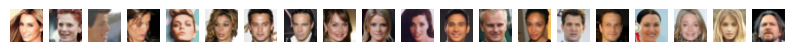

In [18]:
import pickle
import matplotlib.pyplot as plt

# Function to load and display images from pickled data
def display_images_from_pickle(pickle_file, num_images=20):
    # Load the pickled data
    with open(pickle_file, "rb") as f:
        images, labels = pickle.load(f)

    # Plot the first few images
    plt.figure(figsize=(10, 2))
    for i in range(min(num_images, len(images))):
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to HWC format for plotting
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

# Example usage: load and display images from the first batch
sample_pickle_file = os.path.join(output_dir, "celeba32_batch_1.pkl")
display_images_from_pickle(sample_pickle_file)


In [ ]:
import zipfile
from tqdm import tqdm
import os

def extract_zip(zip_path: str, extract_to: str):
    """Extracts a zip file to a specified directory with a progress bar."""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get list of all files in the zip
        total_files = len(zip_ref.infolist())
        
        # Iterate over each file in the zip archive
        with tqdm(total=total_files, desc="Extracting", unit="file") as pbar:
            for file in zip_ref.infolist():
                zip_ref.extract(file, extract_to)
                pbar.update(1)

if __name__ == "__main__":
    zip_path = 'data/CELEBA/archive.zip'
    extract_to = 'data/CELEBA'
    
    # Ensure the output directory exists
    os.makedirs(extract_to, exist_ok=True)
    
    extract_zip(zip_path, extract_to)

In [2]:
import lmdb

lmdb_path = "D:/repos/ood_detection/data/IMAGENET32/train.lmdb"

# Open the LMDB file
env = lmdb.open(lmdb_path, readonly=True, lock=False)

missing_keys = []
with env.begin(write=False) as txn:
    # for i in range(1281167):  # Expected range based on your description
    key = f"{1281167:08}".encode("ascii")
    if txn.get(key) is None:
        missing_keys.append(key)

env.close()

if missing_keys:
    print(f"Missing keys: {missing_keys[:10]}... (total missing: {len(missing_keys)})")
else:
    print("All keys are present in LMDB.")


Missing keys: [b'01281167']... (total missing: 1)


In [1]:
from utilities.utils import dataset_names, to_dataset_wrapper
# Load other dataset_name as test
fit_dataset_name = 'cifar10'
dataset_names.remove(fit_dataset_name)
test_dataset_names = dataset_names
test_dataset_names

{'celeba', 'gtsrb', 'imagenet32', 'svhn'}

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from utilities.routes import DATAROOT
from data.datasets import ImageNet32Wrapper, GTSRBWrapper
class CombinedDataset(Dataset):
    """A dataset that combines ImageNet32 and GTSRB datasets."""

    def __init__(self, dataset1, dataset2, balance_ratio=0.5):
        """
        Initializes the combined dataset.

        Args:
            dataset1: First dataset (ImageNet32).
            dataset2: Second dataset (GTSRB).
            balance_ratio: Fraction of samples from dataset1 in each batch.
                           A value of 0.5 means equal samples from both datasets.
        """
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.balance_ratio = balance_ratio
        self.length1 = len(dataset1)
        self.length2 = len(dataset2)
        self.total_length = self.length1 + self.length2

    def __len__(self):
        return self.total_length

    def __getitem__(self, index):
        # Decide which dataset to sample from based on the balance ratio
        if torch.rand(1).item() < self.balance_ratio:
            dataset, idx = self.dataset1, index % self.length1
        else:
            dataset, idx = self.dataset2, index % self.length2
        return dataset[idx]

# Example usage
def load_combined_train_dataset(dataroot):
    """Loads and combines ImageNet32 and GTSRB training datasets."""
    imagenet_train = ImageNet32Wrapper.get_train(dataroot)
    gtsrb_train = GTSRBWrapper.get_train(dataroot)
    
    # Combine with a 50% balance ratio for each dataset
    combined_train_dataset = CombinedDataset(imagenet_train, gtsrb_train, balance_ratio=0.5)
    return combined_train_dataset

def load_combined_test_dataset(dataroot):
    """Loads and combines ImageNet32 and GTSRB test datasets."""
    imagenet_test = ImageNet32Wrapper.get_test(dataroot)
    gtsrb_test = GTSRBWrapper.get_test(dataroot)
    
    # Combine with a 50% balance ratio for each dataset
    combined_test_dataset = CombinedDataset(imagenet_test, gtsrb_test, balance_ratio=0.5)
    return combined_test_dataset

# DataLoader example
dataroot = DATAROOT
train_dataset = load_combined_train_dataset(dataroot)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = load_combined_test_dataset(dataroot)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Total entries in LMDB: 128116


Loading training data from ImageNet32: 100%|██████████| 128116/128116 [01:11<00:00, 1798.31it/s]


Total entries in LMDB: 50000


Loading validation data of ImageNet32: 100%|██████████| 50000/50000 [00:09<00:00, 5181.06it/s]


In [9]:
from utilities.utils import dataset_names, to_dataset_wrapper

for ds in dataset_names:
    ds_wrapper = to_dataset_wrapper[ds]
    train_ds = ds_wrapper.get_train(hparams['dataroot'])
    test_ds = ds_wrapper.get_test(hparams['dataroot'])
    print(f"Dataset: {ds}")
    print(f"Train length: {len(train_ds)}")
    print(f"Test length: {len(test_ds)}\n")

Total entries in LMDB split): 162079


Loading training data of CelebA: 100%|██████████| 162079/162079 [03:59<00:00, 678.00it/s]


Total entries in LMDB split): 40520


Loading validation data of CelebA: 100%|██████████| 40520/40520 [00:58<00:00, 697.84it/s]


Dataset: celeba
Train length: 162079
Test length: 40520

Using downloaded and verified file: /net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/data/SVHN/train_32x32.mat
Using downloaded and verified file: /net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/data/SVHN/test_32x32.mat
Dataset: svhn
Train length: 73257
Test length: 26032

Dataset: gtsrb
Train length: 26640
Test length: 12630

Files already downloaded and verified
Files already downloaded and verified
Dataset: cifar10
Train length: 50000
Test length: 10000

Total entries in LMDB: 128116


Loading training data from ImageNet32: 100%|██████████| 128116/128116 [00:44<00:00, 2893.86it/s]


Total entries in LMDB: 50000


Loading validation data of ImageNet32: 100%|██████████| 50000/50000 [00:10<00:00, 4690.00it/s]


Dataset: mixed
Train length: 154756
Test length: 62630

Total entries in LMDB: 128116


Loading training data from ImageNet32: 100%|██████████| 128116/128116 [00:44<00:00, 2902.03it/s]


Total entries in LMDB: 50000


Loading validation data of ImageNet32: 100%|██████████| 50000/50000 [00:10<00:00, 4695.81it/s]


Dataset: imagenet32
Train length: 128116
Test length: 50000



In [ ]:
""" Class to extract OOD scores from a model."""
import random
from os import makedirs, path

import torch
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

from ood_scores.scores.g_nll import OODScores
from utilities.routes import PathCreator


class OODScoresExtractor(OODScores):
    """ Class to extract OOD scores from a model."""

    def __init__(self, model, device):
        super().__init__(model, device)
        self.model = self.model.to(self.device).eval()
        self.path_creator = PathCreator()
        self.fit_ds_name = None

    def ood_scores_on_batches(self, dataset, batch_size, means, variances, num_samples, checkpoint, fit=False):
        """Compute OOD scores for each sample in the batch"""

        checkpoint_number = int(''.join(filter(str.isdigit, checkpoint)))
        ds_name = getattr(dataset, 'name', dataset.__class__.__name__).lower()
        # Compute OOD scores for Fit dataset
        if fit:
            self.fit_ds_name = ds_name
            output_dir = self.path_creator.model_dataset_path(self.model.__class__.__name__.lower(), self.fit_ds_name)
            output_dir = path.join(output_dir, str(batch_size))
            if not path.exists(output_dir):
                makedirs(output_dir)
            file_dir = f"{output_dir}/ood_scores_fit_samples_b{batch_size}_{self.fit_ds_name}_using_checkpoint_{checkpoint_number}.pth"
            if not path.exists(file_dir):
                ood_scores_fit_samples, features, num_features, features_scalar  = self.run_ood_scores(dataset, batch_size, means, variances, num_samples)
                torch.save({
                    'ood_scores': ood_scores_fit_samples,
                    'features': features,
                    'num_features': num_features,
                    'features_scalar': features_scalar
                }, file_dir)
                # torch.save(ood_scores_fit_samples, file_dir)
                print(f"fit_ood_scores of {self.fit_ds_name} is saved in\n {file_dir}")
            else:
                print(f"fit_ood_scores of {self.fit_ds_name} already exists in\n {file_dir}")
        else:
            # Compute OOD scores for Test dataset
            output_dir = self.path_creator.model_dataset_path(self.model.__class__.__name__.lower(), self.fit_ds_name)
            output_dir = path.join(output_dir, str(batch_size))
            if not path.exists(output_dir):
                makedirs(output_dir)
            file_dir = f"{output_dir}/ood_scores_test_samples_b{batch_size}_{ds_name}_on_{self.fit_ds_name}_using_checkpoint_{checkpoint_number}.pth"
            if not path.exists(file_dir):
                ood_scores_test_samples, features, num_features, features_scalar = self.run_ood_scores(dataset, batch_size, means, variances, num_samples)
                torch.save({
                    'ood_scores': ood_scores_test_samples,
                    'features': features,
                    'num_features': num_features,
                    'features_scalar': features_scalar
                }, file_dir)
                # torch.save(ood_scores_test_samples, file_dir)
                print(f"Test_ood_scores of {ds_name} is saved in\n {file_dir}")
            else:
                print(f"Test_ood_scores of {ds_name} already exists in\n {file_dir}")

    def run_ood_scores(self, ds, b_size, means, variances, num_samples):
        """Compute OOD scores for each sample in the batch"""
        # Create a subset of the test_dataset using the random indices
        random_indices = random.sample(range(len(ds)), num_samples)
        subset = Subset(ds, random_indices)
        loader = DataLoader(subset, batch_size=b_size, shuffle=False)
        ds_name = getattr(ds, 'name', ds.__class__.__name__).lower()

        ood_scores_test_samples = []
        for samples, _ in tqdm(loader, desc=f"Calculating ood_scores on {ds_name} samples"):
            samples = samples.to(self.device)
            # Compute the OOD scores for the test samples
            ood_scores, features, num_features, features_scalar = self.ood_score(samples, means, variances)
            ood_scores_test_samples.append(ood_scores)
        return ood_scores_test_samples, features, num_features, features_scalar



def normalize_scores(scores, method="zscore"):
    if method == "zscore":
        mean = scores.mean(dim=0)
        std = scores.std(dim=0) + 1e-6  # Avoid division by zero
        return (scores - mean) / std
    elif method == "minmax":
        min_val = scores.min(dim=0, keepdim=True).values
        max_val = scores.max(dim=0, keepdim=True).values
        return (scores - min_val) / (max_val - min_val + 1e-6)
    else:
        return scores  # No normalization

def weighted_sum(scores, weights):
    return torch.sum(scores * weights, dim=1)

# Inside `run_ood_scores` or wherever aggregation occurs
layer_scores = []  # Collect scores for each layer
for samples, _ in tqdm(loader, desc=f"Calculating ood_scores on {ds_name} samples"):
    samples = samples.to(self.device)
    ood_scores, features, num_features, features_scalar = self.ood_score(samples, means, variances)
    normalized_scores = normalize_scores(ood_scores, method="zscore")
    layer_scores.append(normalized_scores)

# Combine layer-wise scores (apply weights if necessary)
weights = torch.tensor([1.0] * num_layers).to(self.device)  # Adjust weights as needed
final_scores = weighted_sum(torch.stack(layer_scores), weights)
